# Дерева рішень. Класифікація. Депозити

Курс: "Математичне моделювання в R"

---

У даній частині навчального процесу потрібно побудувати математичні моделі класифікації клієнтів на основі алгоритму дерева рішень та перевірити їх на тестовій вибірці.

In [1]:
# install.packages("C50")
# install.packages("xgboost")
# install.packages("scorecard")
# install.packages("lightgbm")
# install.packages("Matrix") 
# install.packages("scorecard") 

## Dataset description

**Abstract**

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).



**Data Set Information:**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1. bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2. bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3. bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4. bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).

The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (`yes/no`) a term deposit (variable `y`).

**Attribute Information**


**Input variables: bank client data:**

|No|Title|Description|Data Type|Values|
|---|---|---|---|---|
|1|`age`||numeric||
|2|`job`|type of job|categorical|'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown'|
|3|`marital`| marital status |categorical| 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed|
|4|`education`| |categorical| 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown'|
|5|`default`| has credit in default? |categorical| 'no','yes','unknown'|
|6|`housing`| has housing loan? |categorical| 'no','yes','unknown'|
|7|`loan`| has personal loan? |categorical| 'no','yes','unknown'|


**Input variables: related with the last contact of the current campaign:**

|No|Title|Description|Data Type|Values|
|---|---|---|---|---|
|8| contact| contact communication type |categorical| 'cellular','telephone'|
|9 | month| last contact month of year |categorical| 'jan', 'feb', 'mar', ..., 'nov', 'dec'|
|10 | day_of_week| last contact day of the week |categorical|'mon','tue','wed','thu','fri'|
|11 | duration| last contact duration, in seconds |numeric||. 

`duration` - **_Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this 
input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model._**

**Input variables: other attributes:**

|No|Title|Description|Data Type|Values|
|---|---|---|---|---|
|12 | `campaign`| number of contacts performed during this campaign and for this client |numeric| includes last contact||
|13 | `pdays`|number of days that passed by after the client was last contacted from a previous campaign |numeric| 999 mean client was not previously contacted||
|14 | `previous`| number of contacts performed before this campaign and for this client |numeric||
|15 | `poutcome`| outcome of the previous marketing campaign |categorical| 'failure','nonexistent','success'|

**Input variables: social and economic context attributes**

|No|Title|Description|Data Type|Values|
|---|---|---|---|---|
|16 | `emp.var.rate`| employment variation rate - quarterly indicator |numeric||
|17 | `cons.price.idx`| consumer price index - monthly indicator |numeric||
|18 | `cons.conf.idx`| consumer confidence index - monthly indicator ||numeric||
|19 | `euribor3m`| euribor 3 month rate - daily indicator |numeric||
|20 | `nr.employed`|number of employees - quarterly indicator |numeric||

**Output variable (desired target):**

|No|Title|Description|Data Type|Values|
|---|---|---|---|---|
|21| `y` | has the client subscribed a term deposit? |binary| 'yes','no'|

Source: https://archive.ics.uci.edu/ml/datasets/bank+marketing


---

## Data load and preview

Для початку завантажимо дані у змінну `data`:

In [2]:
data <- read.csv("https://raw.githubusercontent.com/kleban/r-course-eng/main/data/banking.csv", 
                 na.strings = c("", " ", "NA", "NULL"), # fix missing as NA if present
                 stringsAsFactors = TRUE) # set strings as factor, we need this for some algorithms
#use + unknown with na.strings if you want to play with missing
#data <- read.csv("data/banking.csv", na.strings = c("", " ", "NA", "NULL", "unknown"))

Переглянемо структуру вибірки даних з `str()`:

In [3]:
str(data)

'data.frame':	11162 obs. of  17 variables:
 $ age      : int  59 56 41 55 54 42 56 60 37 28 ...
 $ job      : Factor w/ 12 levels "admin.","blue-collar",..: 1 1 10 8 1 5 5 6 10 8 ...
 $ marital  : Factor w/ 3 levels "divorced","married",..: 2 2 2 2 2 3 2 1 2 3 ...
 $ education: Factor w/ 4 levels "primary","secondary",..: 2 2 2 2 3 3 3 2 2 2 ...
 $ default  : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ balance  : int  2343 45 1270 2476 184 0 830 545 1 5090 ...
 $ housing  : Factor w/ 2 levels "no","yes": 2 1 2 2 1 2 2 2 2 2 ...
 $ loan     : Factor w/ 2 levels "no","yes": 1 1 1 1 1 2 2 1 1 1 ...
 $ contact  : Factor w/ 3 levels "cellular","telephone",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ day      : int  5 5 5 5 5 5 6 6 6 6 ...
 $ month    : Factor w/ 12 levels "apr","aug","dec",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ duration : int  1042 1467 1389 579 673 562 1201 1030 608 1297 ...
 $ campaign : int  1 1 1 1 2 2 1 1 1 3 ...
 $ pdays    : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ previous

Переглянемо вигляд перших рядків даних з `head()`:

In [4]:
head(data)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>
1,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
2,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
3,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
4,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
5,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
6,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes


Описова статистика факторів:

In [5]:
summary(data)

      age                 job           marital         education   
 Min.   :18.00   management :2566   divorced:1293   primary  :1500  
 1st Qu.:32.00   blue-collar:1944   married :6351   secondary:5476  
 Median :39.00   technician :1823   single  :3518   tertiary :3689  
 Mean   :41.23   admin.     :1334                   unknown  : 497  
 3rd Qu.:49.00   services   : 923                                   
 Max.   :95.00   retired    : 778                                   
                 (Other)    :1794                                   
 default        balance      housing     loan           contact    
 no :10994   Min.   :-6847   no :5881   no :9702   cellular :8042  
 yes:  168   1st Qu.:  122   yes:5281   yes:1460   telephone: 774  
             Median :  550                         unknown  :2346  
             Mean   : 1529                                         
             3rd Qu.: 1708                                         
             Max.   :81204              

Перевіримо вибірку на наявність пропусків:

 /\     /\
{  `---'  }
{  O   O  }
==>  V <==  No need for mice. This data set is completely observed.
 \  \|/  /
  `-----'



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,
11162,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


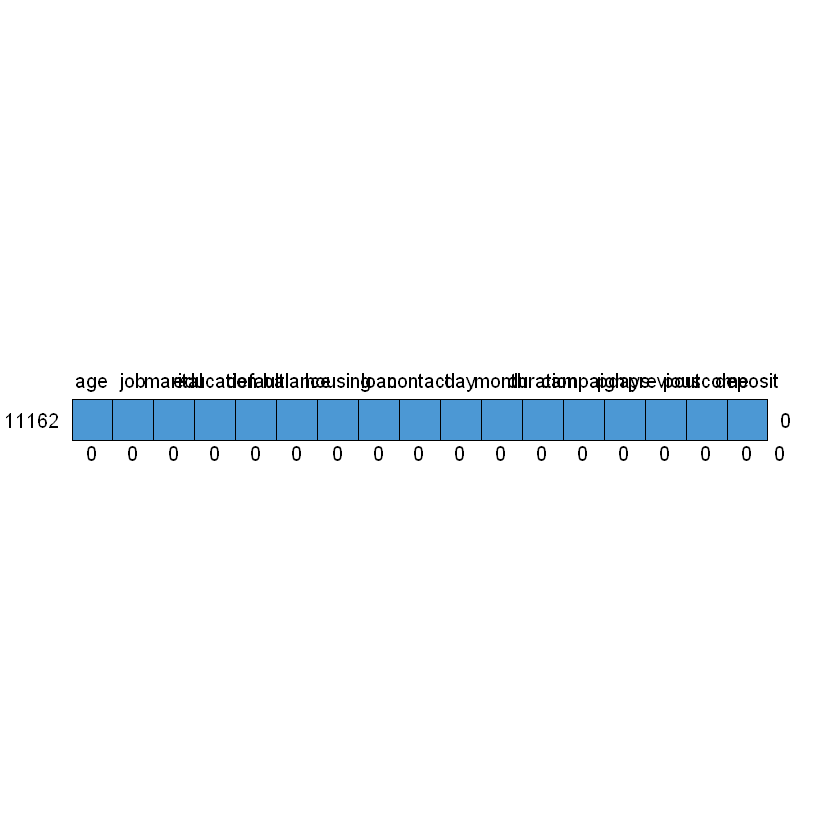

In [6]:
suppressMessages(library(mice))
md.pattern(data) # OK

In [7]:
anyNA(data)

[1] FALSE

---

## Data visualization

**Вік клієнта (age):**

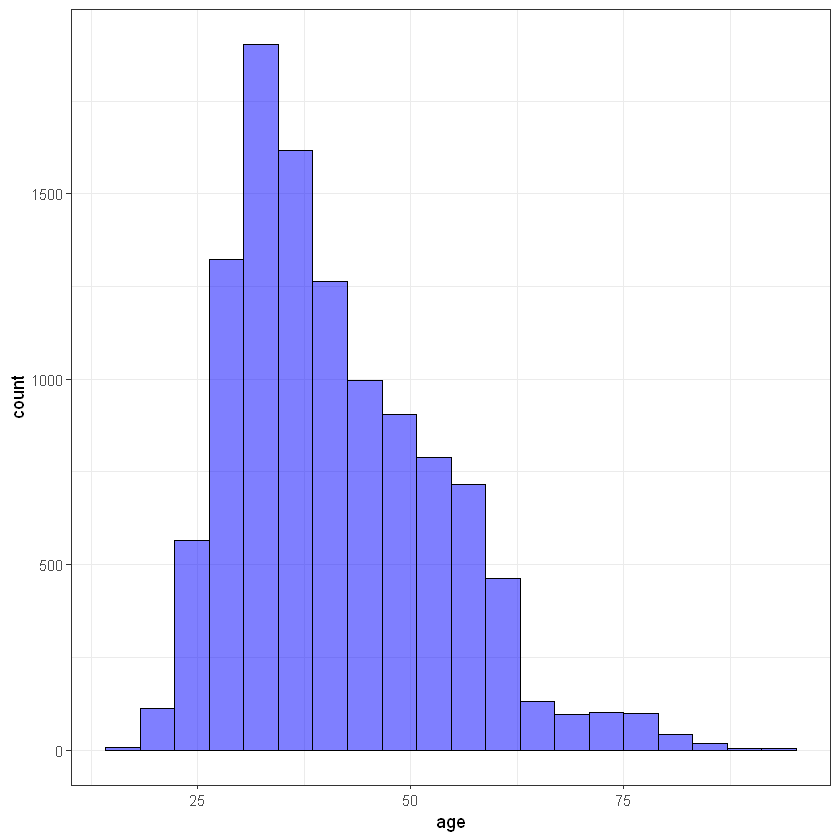

In [8]:
library(ggplot2)

ggplot(data, aes(age)) + 
    geom_histogram(bins = 20, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

**Робота клієнта (job):**

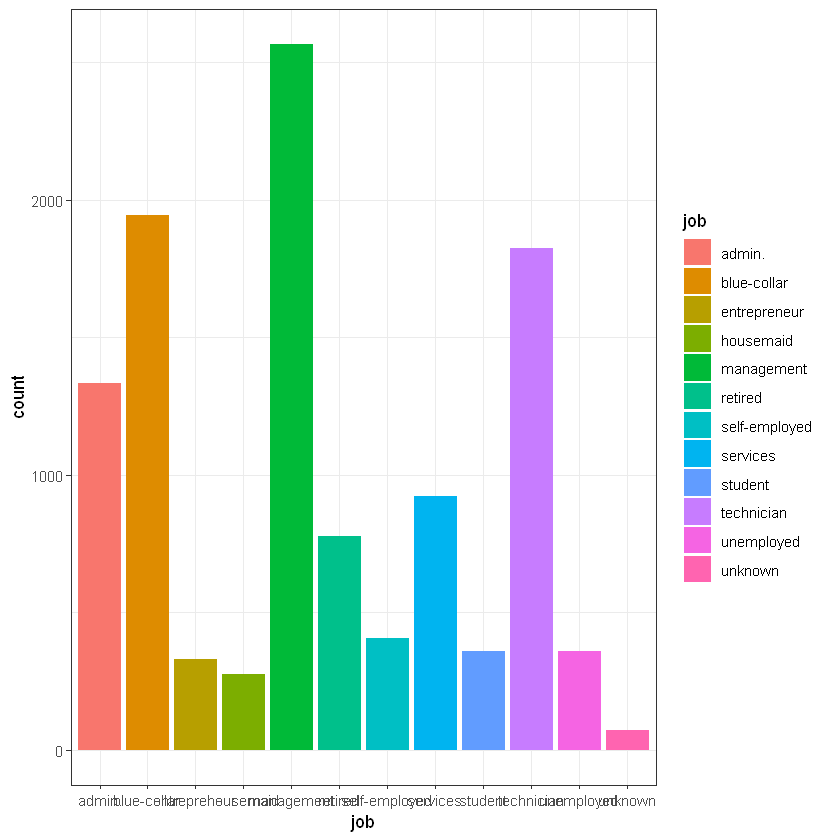

In [9]:
ggplot(data, aes(job)) + 
    geom_bar(aes(fill = job)) + 
    theme_bw()

In [10]:
library(gmodels)
CrossTable(data$job, data$deposit)
# more loyal to deposits are management, retired, student, unemployed ))


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
              | data$deposit 
     data$job |        no |       yes | Row Total | 
--------------|-----------|-----------|-----------|
       admin. |       703 |       631 |      1334 | 
              |     0.002 |     0.002 |           | 
              |     0.527 |     0.473 |     0.120 | 
              |     0.120 |     0.119 |           | 
              |     0.063 |     0.057 |           | 
--------------|-----------|-----------|-----------|
  blue-collar |      1236 |       708 |      1944 | 
              |    44.415 |    49.320 |           | 
              |     0.636 |     0.364 |     0.174 | 
              |     0.210 |     0.134 |           | 
              |     0.111 |     0.063 |           | 
--------------|---------

**Сімейний статус (marital):**

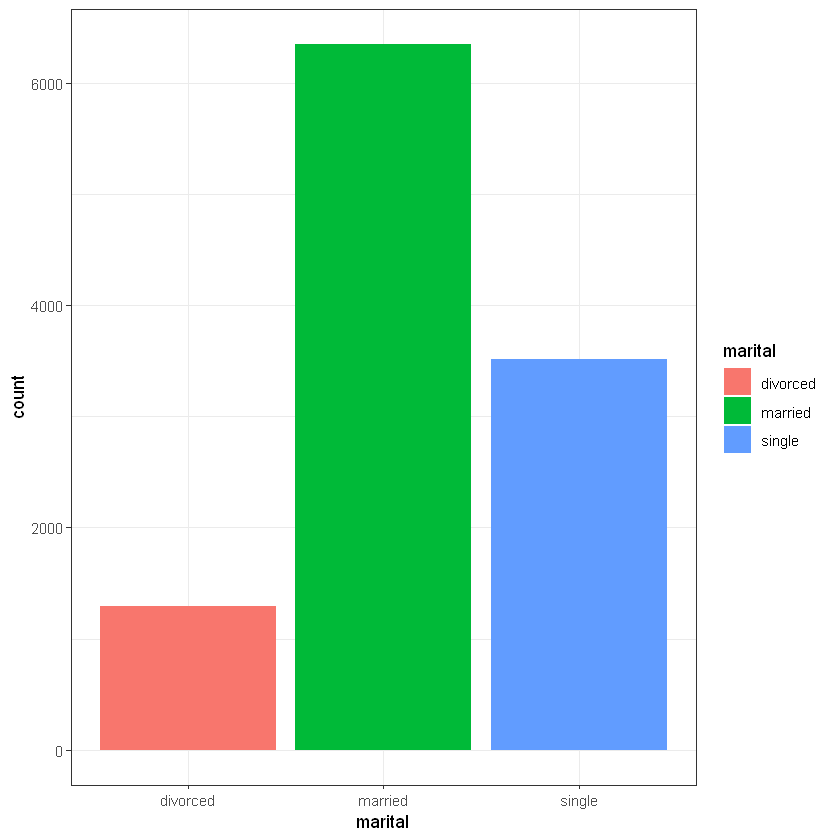

In [11]:
ggplot(data, aes(marital)) + 
    geom_bar(aes(fill = marital)) + 
    theme_bw()

In [12]:
CrossTable(data$marital, data$deposit)
# married are not very loyal to deposits
# but singles is more loyal


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
             | data$deposit 
data$marital |        no |       yes | Row Total | 
-------------|-----------|-----------|-----------|
    divorced |       671 |       622 |      1293 | 
             |     0.128 |     0.142 |           | 
             |     0.519 |     0.481 |     0.116 | 
             |     0.114 |     0.118 |           | 
             |     0.060 |     0.056 |           | 
-------------|-----------|-----------|-----------|
     married |      3596 |      2755 |      6351 | 
             |    19.361 |    21.499 |           | 
             |     0.566 |     0.434 |     0.569 | 
             |     0.612 |     0.521 |           | 
             |     0.322 |     0.247 |           | 
-------------|-----------|-----------|

**Освіта (education):**

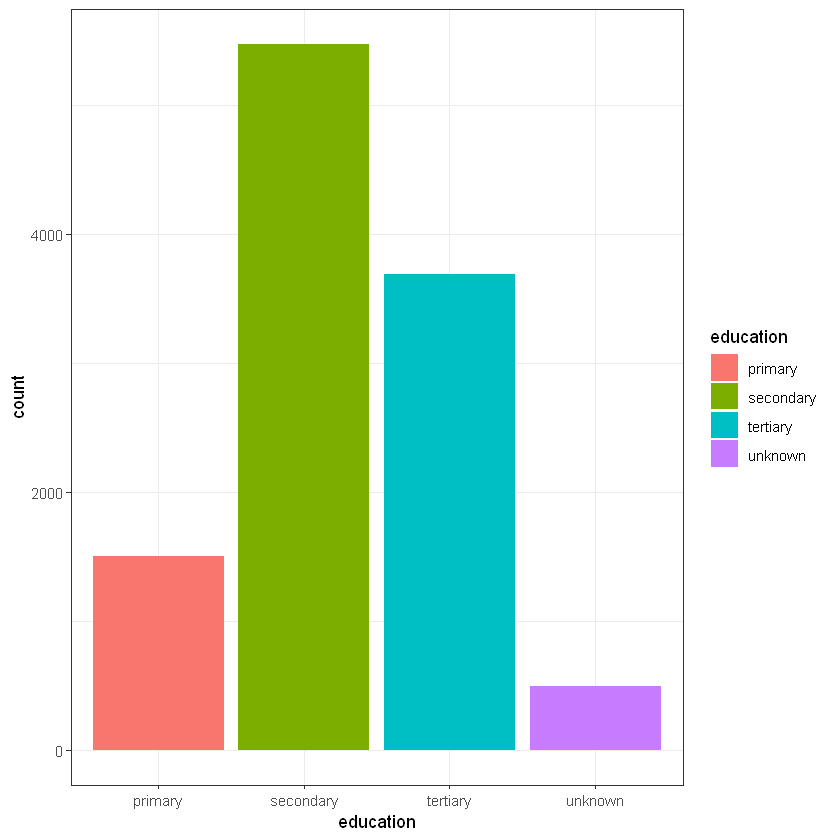

In [13]:
ggplot(data, aes(education)) + 
    geom_bar(aes(fill = education)) + 
    theme_bw()

In [14]:
CrossTable(data$education, data$deposit)
# people with tertiary education is more loyal than other groups


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
               | data$deposit 
data$education |        no |       yes | Row Total | 
---------------|-----------|-----------|-----------|
       primary |       909 |       591 |      1500 | 
               |    18.172 |    20.179 |           | 
               |     0.606 |     0.394 |     0.134 | 
               |     0.155 |     0.112 |           | 
               |     0.081 |     0.053 |           | 
---------------|-----------|-----------|-----------|
     secondary |      3026 |      2450 |      5476 | 
               |     7.272 |     8.075 |           | 
               |     0.553 |     0.447 |     0.491 | 
               |     0.515 |     0.463 |           | 
               |     0.271 |     0.219 |           | 
----------

**Дефолт (default):**

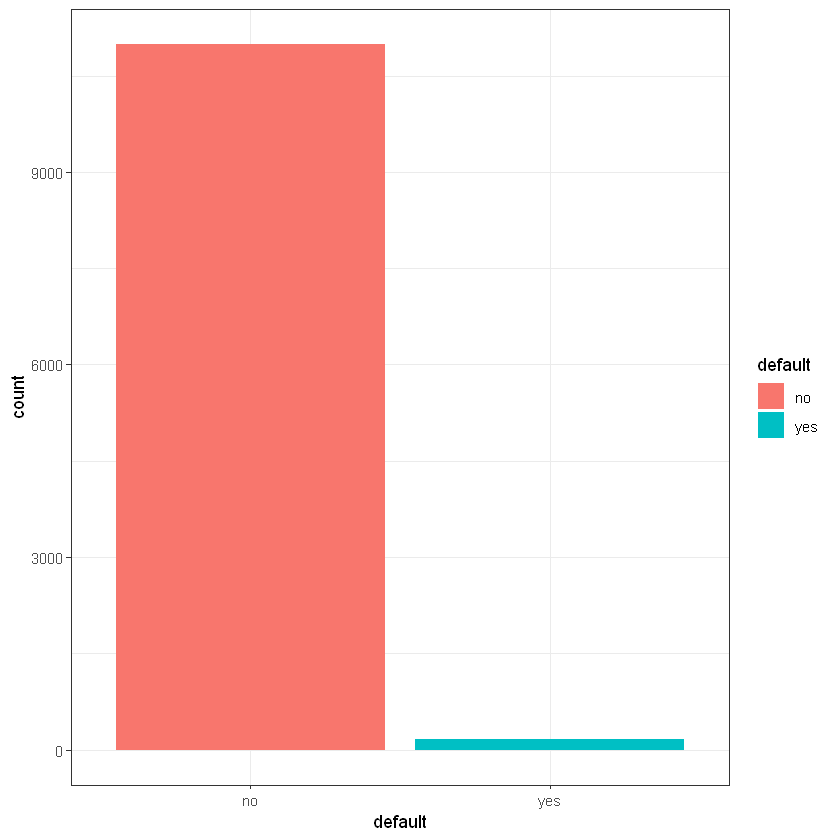

In [15]:
ggplot(data, aes(default)) + 
    geom_bar(aes(fill = default)) + 
    theme_bw()

In [16]:
CrossTable(data$default, data$deposit)
# defaults not very loyal to deposits, but why? ))))))


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
             | data$deposit 
data$default |        no |       yes | Row Total | 
-------------|-----------|-----------|-----------|
          no |      5757 |      5237 |     10994 | 
             |     0.132 |     0.146 |           | 
             |     0.524 |     0.476 |     0.985 | 
             |     0.980 |     0.990 |           | 
             |     0.516 |     0.469 |           | 
-------------|-----------|-----------|-----------|
         yes |       116 |        52 |       168 | 
             |     8.621 |     9.573 |           | 
             |     0.690 |     0.310 |     0.015 | 
             |     0.020 |     0.010 |           | 
             |     0.010 |     0.005 |           | 
-------------|-----------|-----------|

**Баланс (balance):**

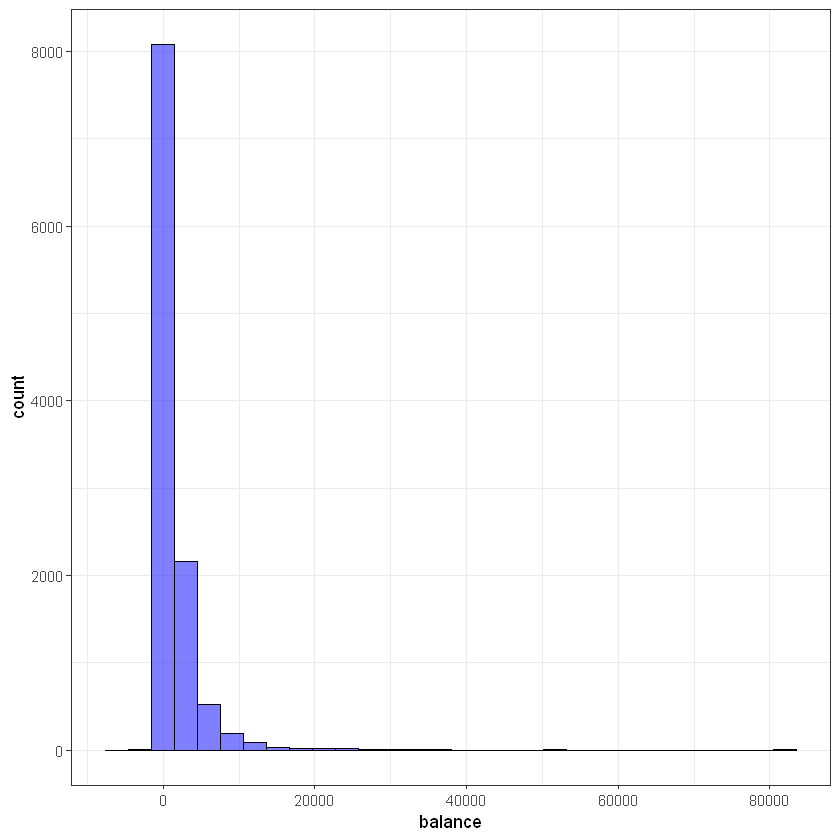

In [17]:
ggplot(data, aes(balance)) + 
    geom_histogram(bins = 30, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

# looks like balance data has outliers

**Наявність кредиту на житло (housing):**

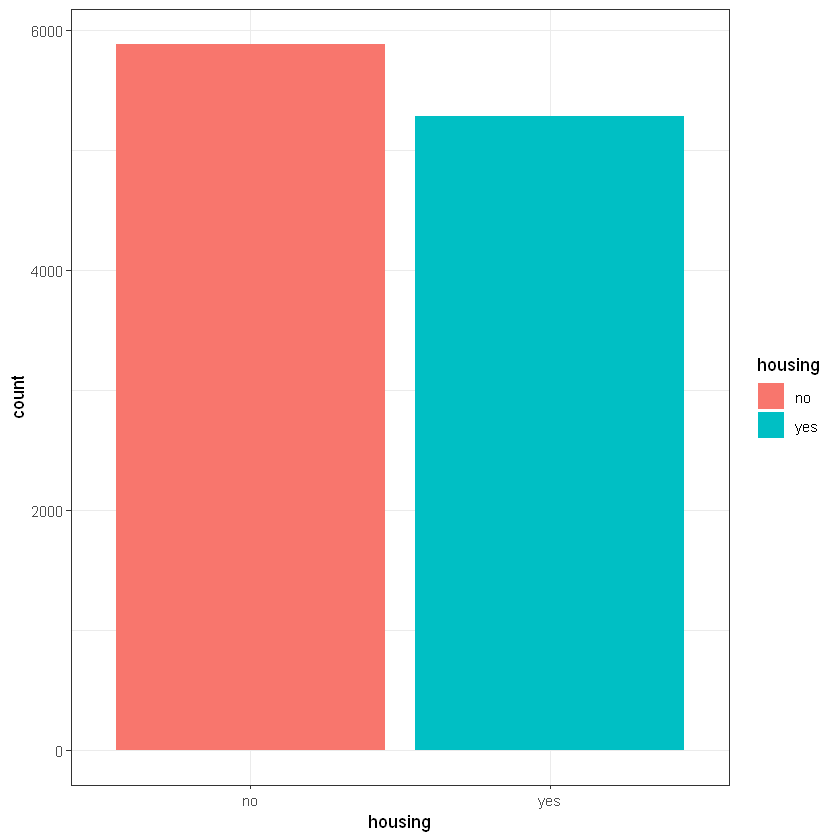

In [18]:
ggplot(data, aes(housing)) + 
    geom_bar(aes(fill = housing)) + 
    theme_bw()

In [19]:
CrossTable(data$housing, data$deposit)
# people without housing load logicaly more often can do deposits


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
             | data$deposit 
data$housing |        no |       yes | Row Total | 
-------------|-----------|-----------|-----------|
          no |      2527 |      3354 |      5881 | 
             |   104.023 |   115.509 |           | 
             |     0.430 |     0.570 |     0.527 | 
             |     0.430 |     0.634 |           | 
             |     0.226 |     0.300 |           | 
-------------|-----------|-----------|-----------|
         yes |      3346 |      1935 |      5281 | 
             |   115.842 |   128.633 |           | 
             |     0.634 |     0.366 |     0.473 | 
             |     0.570 |     0.366 |           | 
             |     0.300 |     0.173 |           | 
-------------|-----------|-----------|

**Наявність позики (loan):**

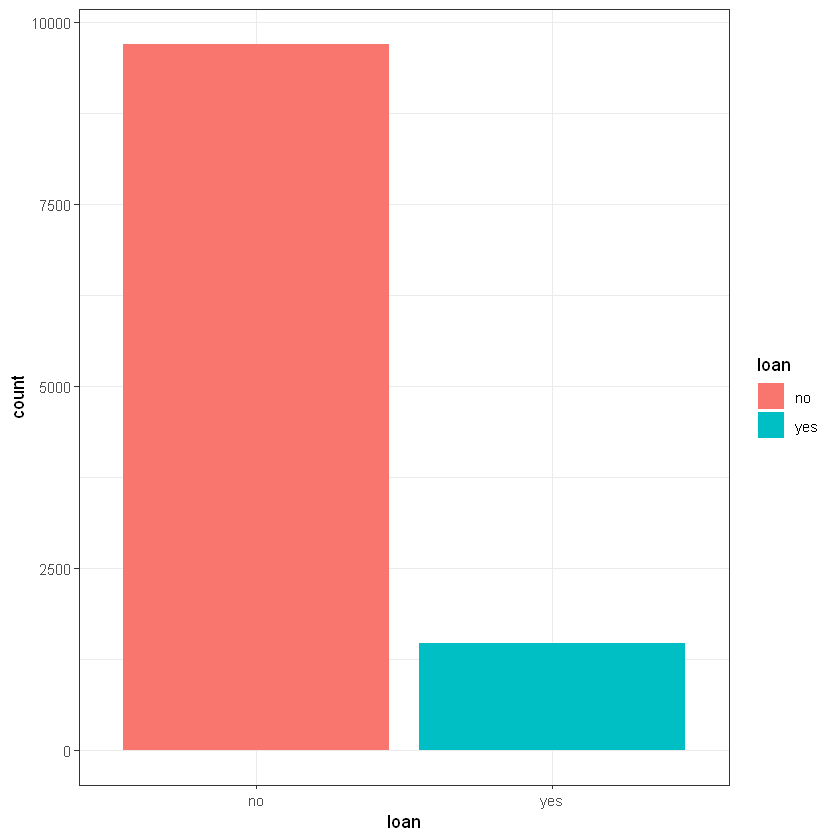

In [20]:
ggplot(data, aes(loan)) + 
    geom_bar(aes(fill = loan)) + 
    theme_bw()

In [21]:
CrossTable(data$loan, data$deposit)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
             | data$deposit 
   data$loan |        no |       yes | Row Total | 
-------------|-----------|-----------|-----------|
          no |      4897 |      4805 |      9702 | 
             |     8.459 |     9.393 |           | 
             |     0.505 |     0.495 |     0.869 | 
             |     0.834 |     0.908 |           | 
             |     0.439 |     0.430 |           | 
-------------|-----------|-----------|-----------|
         yes |       976 |       484 |      1460 | 
             |    56.214 |    62.421 |           | 
             |     0.668 |     0.332 |     0.131 | 
             |     0.166 |     0.092 |           | 
             |     0.087 |     0.043 |           | 
-------------|-----------|-----------|

**# Тип комунікації (contact):**

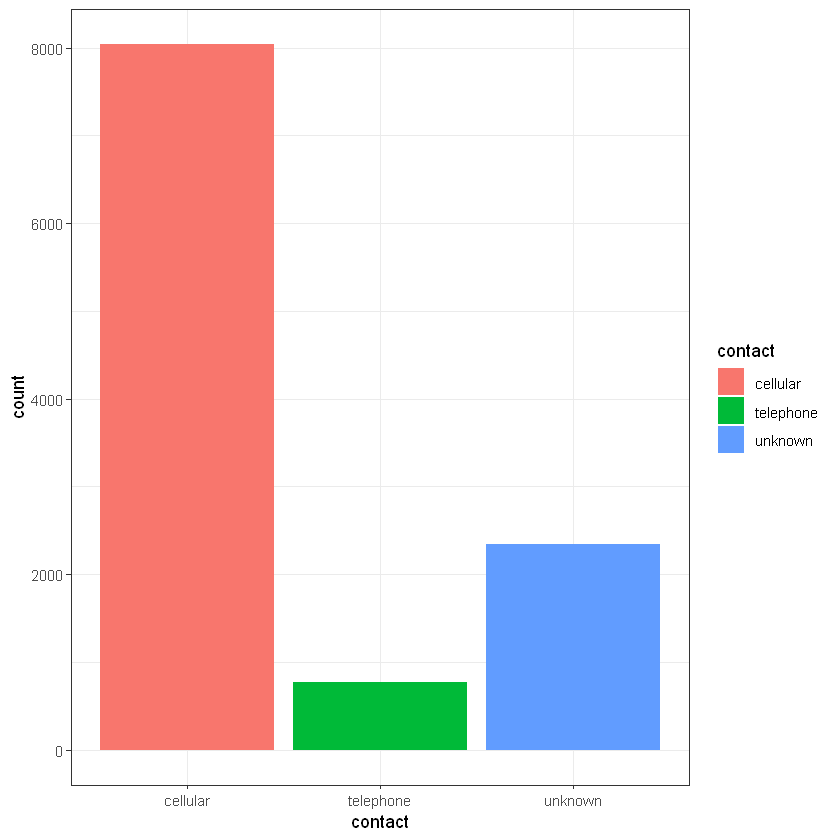

In [22]:
ggplot(data, aes(contact)) + 
    geom_bar(aes(fill = contact)) + 
    theme_bw()

In [23]:
CrossTable(data$contact, data$deposit)
# cellular communication channel looks like the best way to increase deposits count
# people with cellular devices has more money? 


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
             | data$deposit 
data$contact |        no |       yes | Row Total | 
-------------|-----------|-----------|-----------|
    cellular |      3673 |      4369 |      8042 | 
             |    73.685 |    81.821 |           | 
             |     0.457 |     0.543 |     0.720 | 
             |     0.625 |     0.826 |           | 
             |     0.329 |     0.391 |           | 
-------------|-----------|-----------|-----------|
   telephone |       384 |       390 |       774 | 
             |     1.327 |     1.474 |           | 
             |     0.496 |     0.504 |     0.069 | 
             |     0.065 |     0.074 |           | 
             |     0.034 |     0.035 |           | 
-------------|-----------|-----------|

**День місяця (day):**

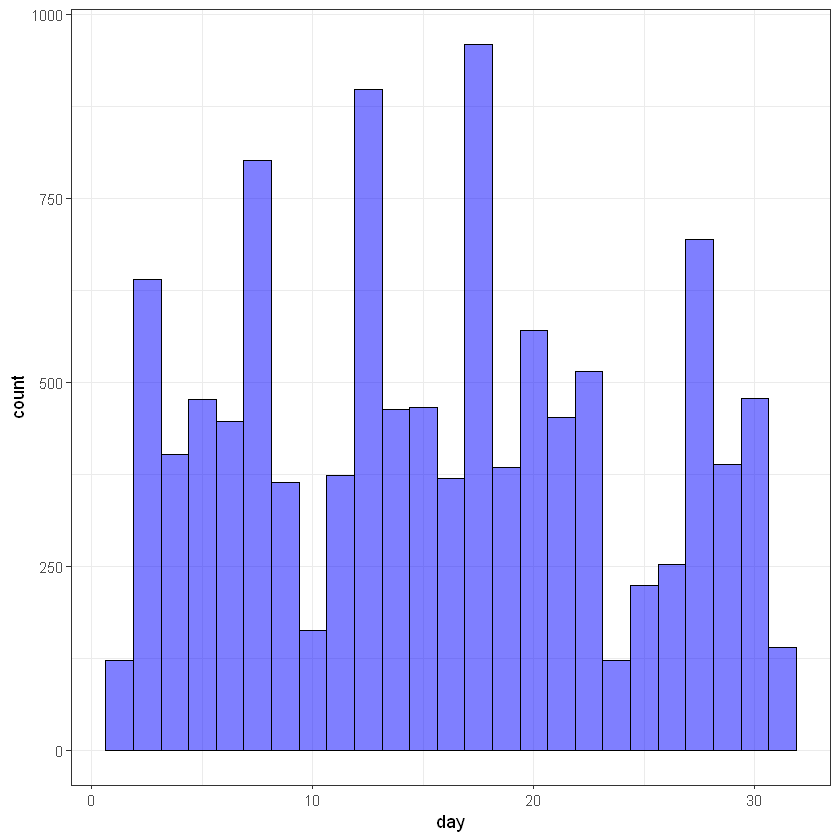

In [24]:
ggplot(data, aes(day)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

**Місяць (month):**

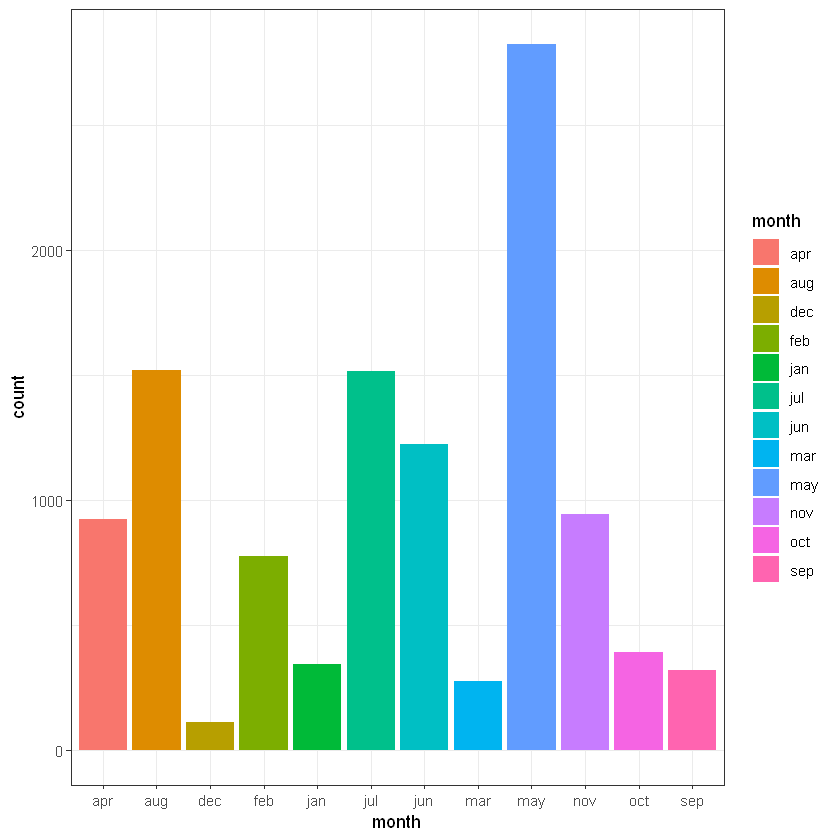

In [25]:
ggplot(data, aes(month)) + 
    geom_bar(aes(fill = month)) + 
    theme_bw()

In [26]:
# So, lets replace our month with ordered factor for correct visualization
suppressMessages(library(dplyr))
data <- data |>
    mutate(month = factor(month, levels=c("jan","feb","mar",
               "apr","may","jun","jul","aug","sep",
              "oct","nov","dec"),ordered=TRUE))

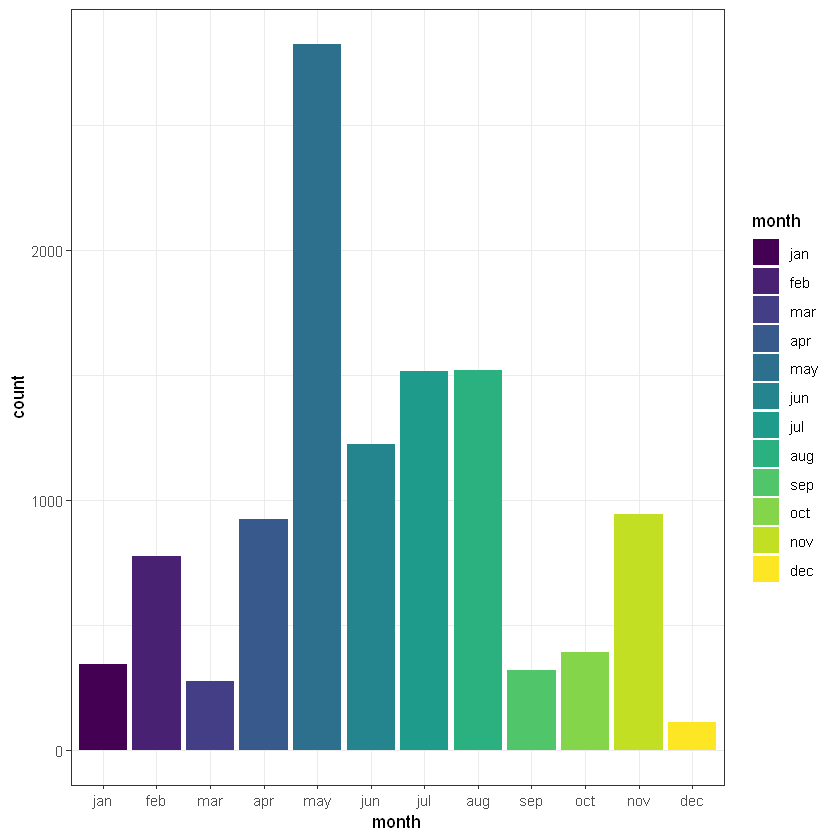

In [27]:
ggplot(data, aes(month)) + 
    geom_bar(aes(fill = month)) + 
    theme_bw()

In [28]:
CrossTable(data$month, data$deposit)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
             | data$deposit 
  data$month |        no |       yes | Row Total | 
-------------|-----------|-----------|-----------|
         jan |       202 |       142 |       344 | 
             |     2.437 |     2.706 |           | 
             |     0.587 |     0.413 |     0.031 | 
             |     0.034 |     0.027 |           | 
             |     0.018 |     0.013 |           | 
-------------|-----------|-----------|-----------|
         feb |       335 |       441 |       776 | 
             |    13.159 |    14.612 |           | 
             |     0.432 |     0.568 |     0.070 | 
             |     0.057 |     0.083 |           | 
             |     0.030 |     0.040 |           | 
-------------|-----------|-----------|

**Тривалість останнього контакту (duration):**

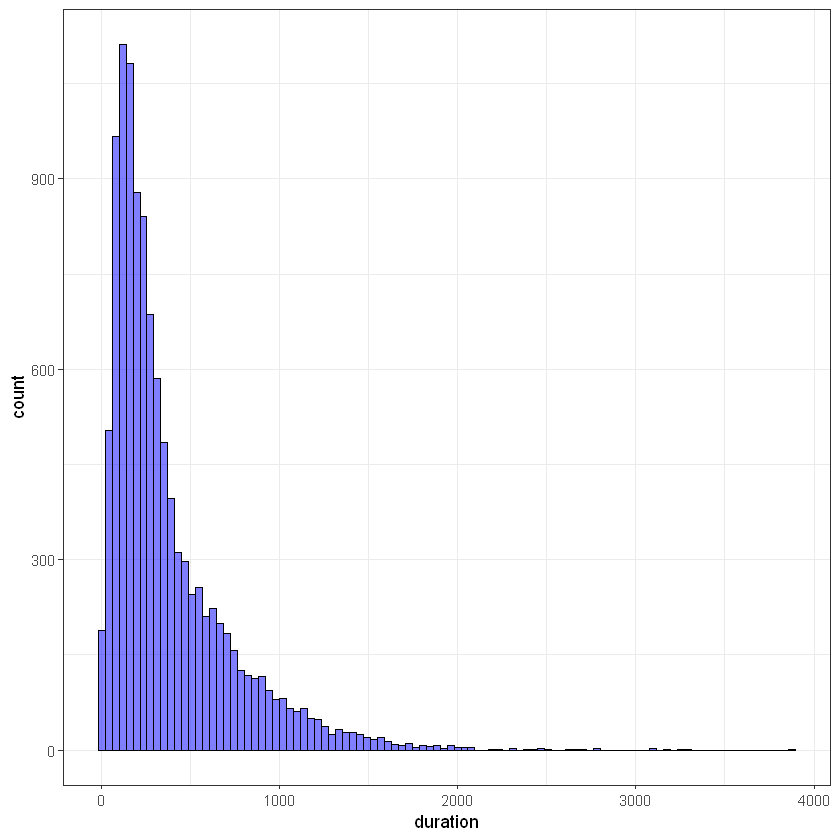

In [29]:
ggplot(data, aes(duration)) + 
    geom_histogram(bins = 100, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

**Кількість контактів протягом поточної кампанії (campaign):**

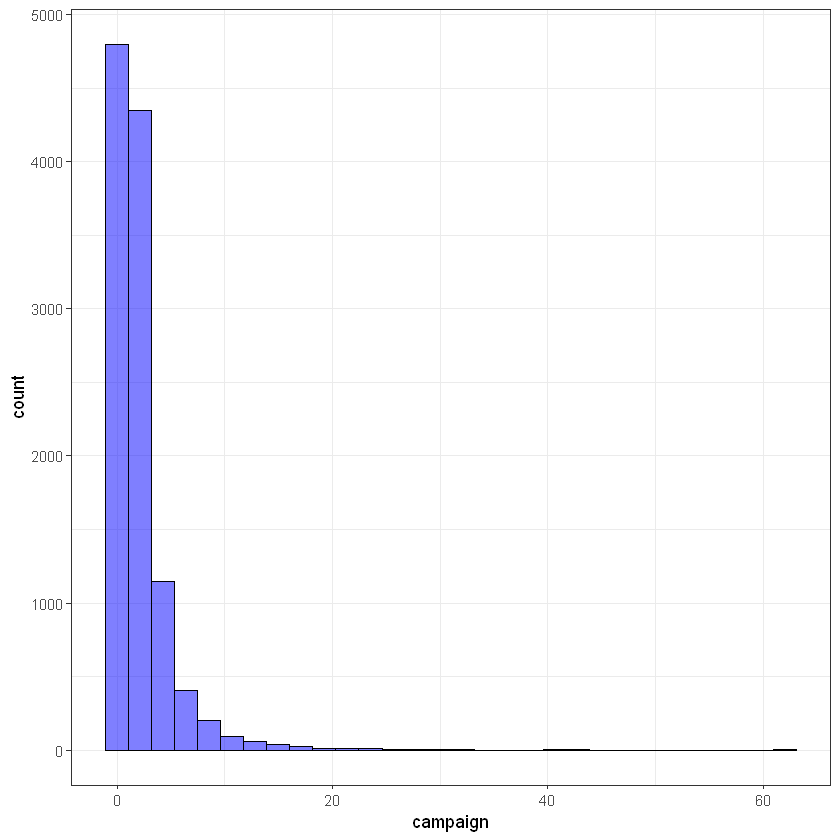

In [30]:
ggplot(data, aes(campaign)) + 
    geom_histogram(bins = 30, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

**Кількість днів від попередньої акції (pday):**

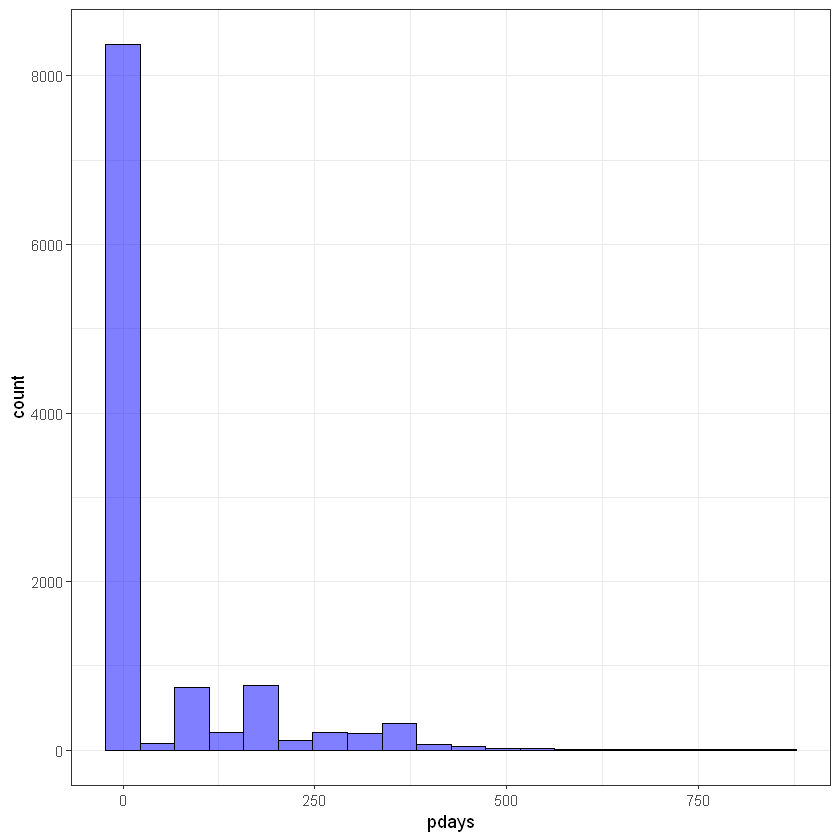

In [31]:
ggplot(data, aes(pdays)) + 
    geom_histogram(bins = 20, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

**Кількість контактів до початку поточної кампанії (previous):**

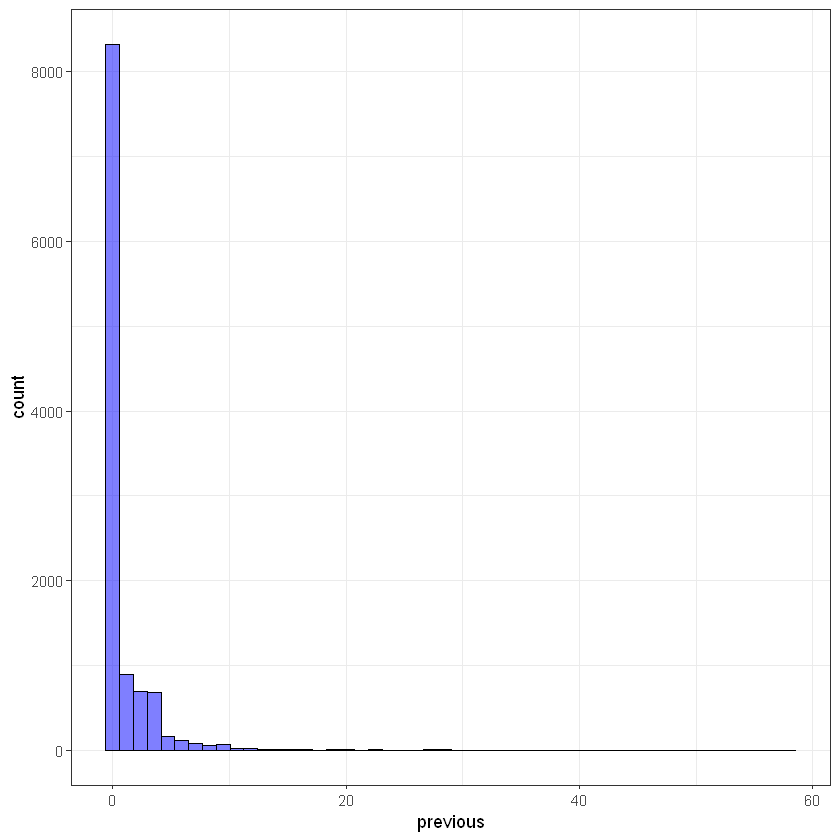

In [32]:
ggplot(data, aes(previous)) + 
    geom_histogram(bins = 50, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

**Результат попередньої кампанії (poutcome):**

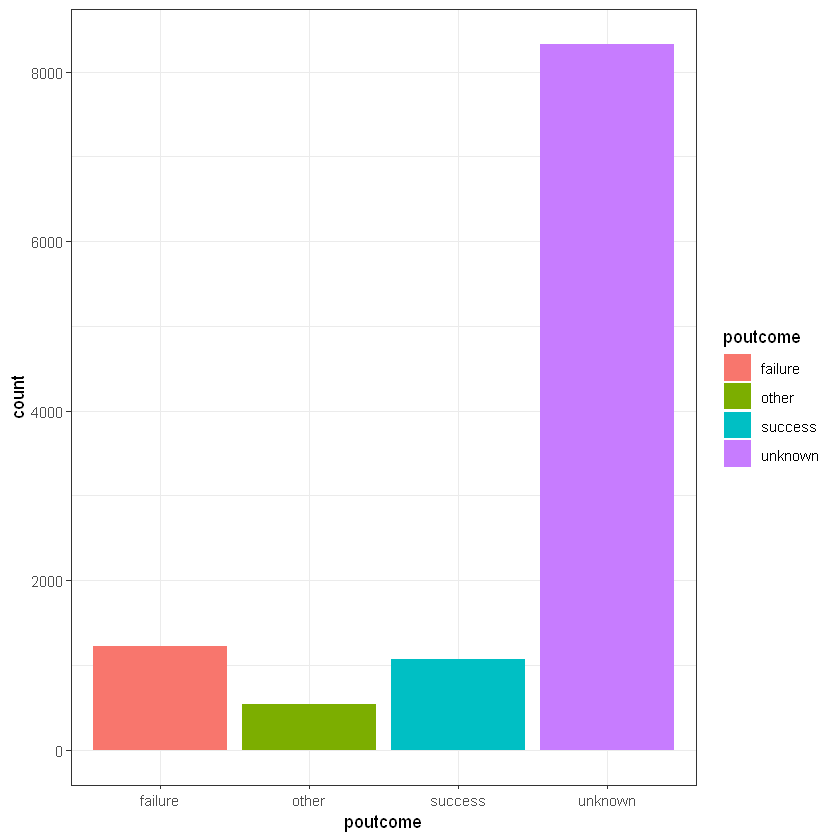

In [33]:
ggplot(data, aes(poutcome)) + 
    geom_bar(aes(fill = poutcome)) + 
    theme_bw()

In [34]:
CrossTable(data$poutcome, data$deposit)
# people with previous success status also loyal for new propositions


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
              | data$deposit 
data$poutcome |        no |       yes | Row Total | 
--------------|-----------|-----------|-----------|
      failure |       610 |       618 |      1228 | 
              |     2.020 |     2.243 |           | 
              |     0.497 |     0.503 |     0.110 | 
              |     0.104 |     0.117 |           | 
              |     0.055 |     0.055 |           | 
--------------|-----------|-----------|-----------|
        other |       230 |       307 |       537 | 
              |     9.773 |    10.852 |           | 
              |     0.428 |     0.572 |     0.048 | 
              |     0.039 |     0.058 |           | 
              |     0.021 |     0.028 |           | 
--------------|---------

**Результат укладання або відсутність укладання договору (deposit):**

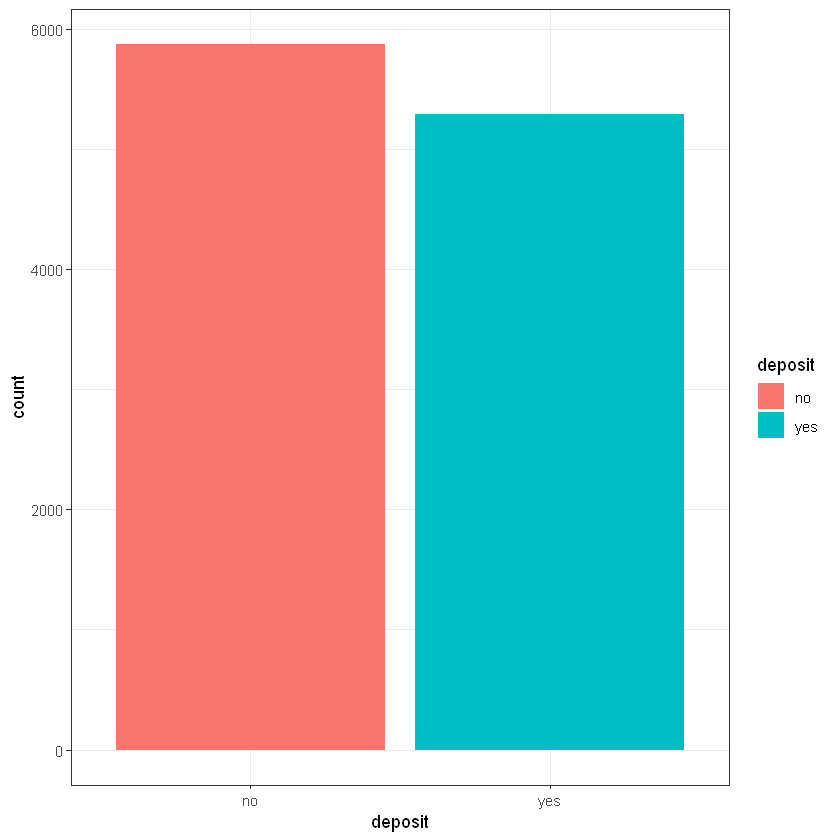

In [35]:
ggplot(data, aes(deposit)) + 
    geom_bar(aes(fill = deposit)) + 
    theme_bw()

In [36]:
CrossTable(data$deposit)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  11162 

 
          |        no |       yes | 
          |-----------|-----------|
          |      5873 |      5289 | 
          |     0.526 |     0.474 | 
          |-----------|-----------|



 


## Data preprocessing

Перетворимо значення `deposit` до `0` і `1`:

In [37]:
data$deposit <- ifelse(data$deposit == "yes", 1, 0)

Видалимо `duration`, адже цей параметр чітко вказує на факт укладання угоди, такі дані називаються leak:

In [38]:
data$duration <- NULL

Створимо новий параметр `pdays_flag`, який вказує чи був контакт з клієнтом раніше:

In [39]:
data$pdays_flag <- ifelse(data$pdays > 0, 1, 0)

In [40]:
head(data)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,pdays_flag
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<ord>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>
1,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,1,0
2,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,1,0
3,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,1,0
4,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,1,0
5,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,1,0
6,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,2,-1,0,unknown,1,0


Створимо новий параметр `poutcome_success`, який вказує чи була попередня кампанія з цим клієнтом “успішною для банку”:

In [41]:
data$poutcoume_success <- ifelse(data$poutcome == "success", 1, 0)

---

## Train/test split

Задаємо seed для генератора випадкових чисел

Train  65%, test 35%

In [42]:
set.seed(111) 
suppressMessages(library(caret))
index = createDataPartition(data$deposit, p = 0.65, list = FALSE)
train_data = data[index, ]
test_data = data[-index, ]

In [43]:
CrossTable(train_data$deposit)
CrossTable(test_data$deposit)


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  7256 

 
          |         0 |         1 | 
          |-----------|-----------|
          |      3816 |      3440 | 
          |     0.526 |     0.474 | 
          |-----------|-----------|



 

 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  3906 

 
          |         0 |         1 | 
          |-----------|-----------|
          |      2057 |      1849 | 
          |     0.527 |     0.473 | 
          |-----------|-----------|



 


---

## Decision trees with `rpart()`

Для побудови дерев рішень у `R` є ряд пакетів та алгоритмів. Розглянемо пакет `rpart`.

In [44]:
#install.packages("rpart")
library(rpart)
rpart_model <- rpart(deposit ~ ., train_data)

Виведемо опис моделі:

In [45]:
rpart_model

n= 7256 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 7256 1809.12900 0.4740904  
   2) poutcome=failure,other,unknown 6563 1605.86300 0.4270913  
     4) contact=unknown 1543  272.24240 0.2287751 *
     5) contact=cellular,telephone 5020 1254.28300 0.4880478  
      10) housing=yes 2139  507.93360 0.3880318 *
      11) housing=no 2881  709.06630 0.5623048  
        22) balance< 105.5 636  150.38990 0.3836478 *
        23) balance>=105.5 2245  532.62540 0.6129176 *
   3) poutcome=success 693   51.47475 0.9191919 *

Дуже детальний опис:

In [46]:
summary(rpart_model)

Call:
rpart(formula = deposit ~ ., data = train_data)
  n= 7256 

          CP nsplit rel error    xerror        xstd
1 0.08390285      0 1.0000000 1.0004337 0.001224021
2 0.04385421      1 0.9160972 0.9165627 0.005207633
3 0.02060824      2 0.8722429 0.8731088 0.006530786
4 0.01439973      3 0.8516347 0.8528095 0.007275812
5 0.01000000      4 0.8372350 0.8459897 0.007777416

Variable importance
         poutcome poutcoume_success           contact           housing 
               33                33                17                 8 
          balance               job             pdays             month 
                6                 1                 1                 1 

Node number 1: 7256 observations,    complexity param=0.08390285
  mean=0.4740904, MSE=0.2493287 
  left son=2 (6563 obs) right son=3 (693 obs)
  Primary splits:
      poutcome          splits as  LLRL,      improve=0.08390285, (0 missing)
      poutcoume_success < 0.5   to the left,  improve=0.08390285, (0

Візуалізуємо дерево рішень:

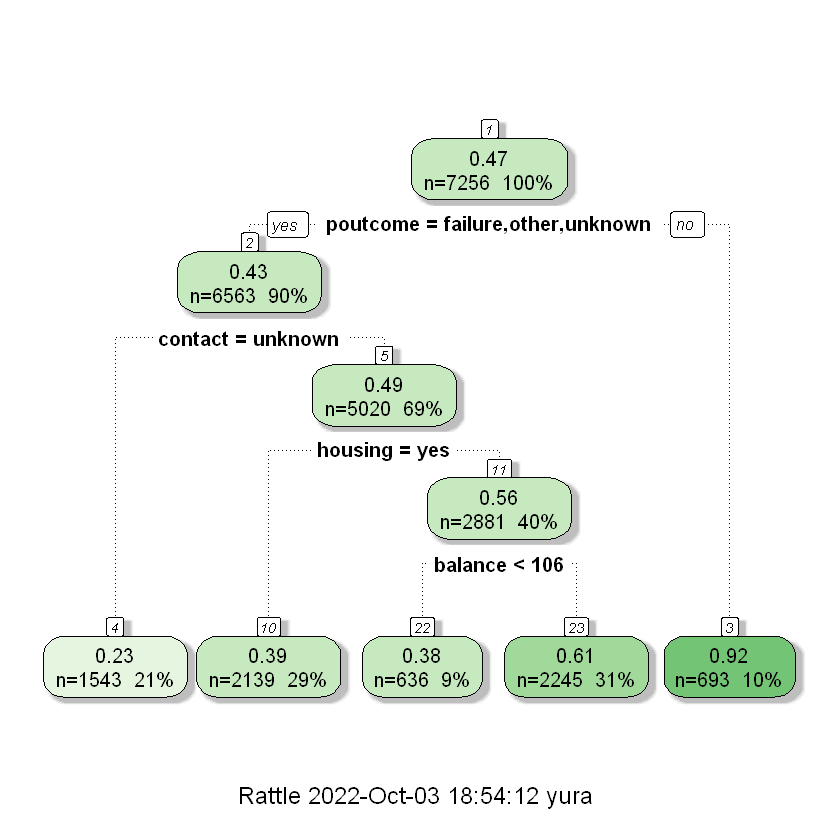

In [47]:
# install.packages(c("rattle", "RColorBrewer"))

suppressMessages(library(rattle))
suppressMessages(library(RColorBrewer))
fancyRpartPlot(rpart_model)

# now you can see how model model works

Створимо два дата-фрейм для для запису результатів моделювання на тестовій вибірці. Одразу додамо у набори даних реальні значення результатів маркетингової акції deposit та модельовані значення

Дані тренувальної вибірки будуть використовуватися для визначення оптимальної cutoff лінії, а тестової для порівняння моделей між собою.

In [48]:
train_results <- data.frame(No = c(1:nrow(train_data)), 
                            deposit = train_data$deposit, 
                            RPartPredicted = predict(rpart_model, train_data))

test_results <- data.frame(No = c(1:nrow(test_data)),
                           deposit = test_data$deposit, 
                           RPartPredicted = predict(rpart_model, test_data))

head(test_results)

,No,deposit,RPartPredicted
,<int>,<dbl>,<dbl>
1,1,1,0.2287751
2,2,1,0.2287751
4,3,1,0.2287751
7,4,1,0.2287751
8,5,1,0.2287751
9,6,1,0.2287751


Визначимо оптимальну лінію розподілу на 0 і 1 для тренувальної вибірки за допомогою пакету `InformationValue`:

In [49]:
suppressMessages(library(InformationValue))
optCutOff <- optimalCutoff(train_results$deposit, train_results$RPartPredicted)
optCutOff

[1] 0.3891919

Побудуємо `ROC`-криву для тестової вибірки:

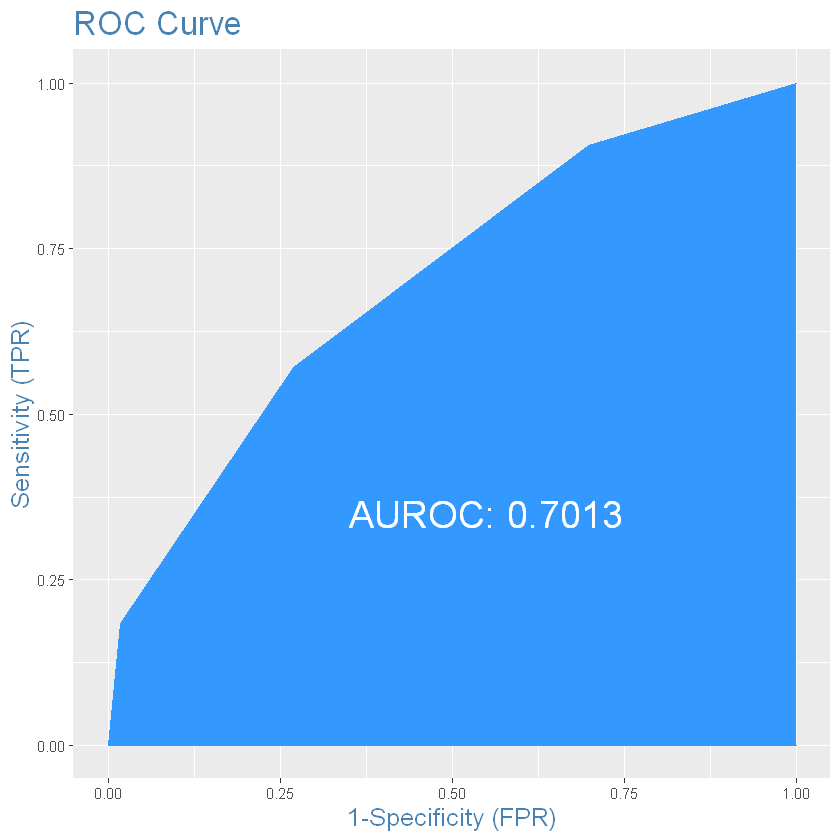

In [50]:
plotROC(test_results$deposit, test_results$RPartPredicted)

Сформуємо набір класів `0` і `1` для тестового набору даних:

In [51]:
test_results$RPartPredicted_Class <- ifelse(test_results$RPartPredicted > optCutOff, 1, 0)

Confusion matrix:

In [52]:
cm <- caret::confusionMatrix(factor(test_results$deposit), 
                      factor(test_results$RPartPredicted_Class), 
                      positive = "1")
cm

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1504  553
         1  793 1056
                                          
               Accuracy : 0.6554          
                 95% CI : (0.6403, 0.6703)
    No Information Rate : 0.5881          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3043          
                                          
 Mcnemar's Test P-Value : 7.297e-11       
                                          
            Sensitivity : 0.6563          
            Specificity : 0.6548          
         Pos Pred Value : 0.5711          
         Neg Pred Value : 0.7312          
             Prevalence : 0.4119          
         Detection Rate : 0.2704          
   Detection Prevalence : 0.4734          
      Balanced Accuracy : 0.6555          
                                          
       'Positive' Class : 1               
                        

Переглянемо збалансовану точність класифіції:

In [53]:
BAcc <- cm$byClass[["Balanced Accuracy"]]
BAcc 

[1] 0.6555377

---

## Desicion trees with  PartyKit

Побудуємо дерево рішень за допоомгою пакету `partykit`:

In [54]:
#install.packages("partykit")
suppressMessages(library(partykit))
head(train_data)
party_model <- ctree(deposit ~ ., data = train_data)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,pdays_flag,poutcoume_success
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<ord>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>
3,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,1,0,0
5,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,1,0,0
6,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,2,-1,0,unknown,1,0,0
11,38,admin.,single,secondary,no,100,yes,no,unknown,7,may,1,-1,0,unknown,1,0,0
12,30,blue-collar,married,secondary,no,309,yes,no,unknown,7,may,2,-1,0,unknown,1,0,0
14,46,blue-collar,single,tertiary,no,460,yes,no,unknown,7,may,2,-1,0,unknown,1,0,0


Виведемо текстовий опис моделі:

In [55]:
party_model
# Looks like this model is more complex


Model formula:
deposit ~ age + job + marital + education + default + balance + 
    housing + loan + contact + day + month + campaign + pdays + 
    previous + poutcome + pdays_flag + poutcoume_success

Fitted party:
[1] root
|   [2] poutcome in failure, other, unknown
|   |   [3] contact in cellular, telephone
|   |   |   [4] housing in no
|   |   |   |   [5] loan in no
|   |   |   |   |   [6] campaign <= 3
|   |   |   |   |   |   [7] job in admin., management, retired, student, unemployed
|   |   |   |   |   |   |   [8] day <= 17: 0.733 (n = 715, err = 140.0)
|   |   |   |   |   |   |   [9] day > 17
|   |   |   |   |   |   |   |   [10] job in admin., management, retired, unemployed: 0.583 (n = 434, err = 105.5)
|   |   |   |   |   |   |   |   [11] job in student: 0.843 (n = 51, err = 6.7)
|   |   |   |   |   |   [12] job in blue-collar, entrepreneur, housemaid, self-employed, services, technician, unknown
|   |   |   |   |   |   |   [13] campaign <= 1: 0.612 (n = 415, err = 98.5)
| 

Візуалізуємо побудоване дерево рішень:

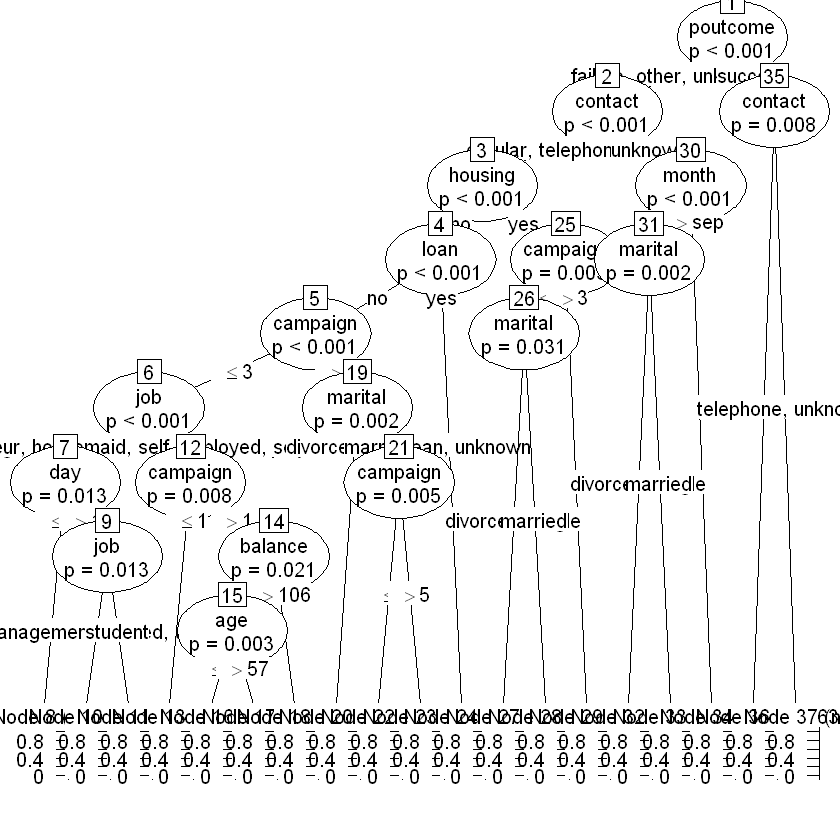

In [56]:
plot(party_model)

Конвернтуємо `ctree()` до `rpart()`:

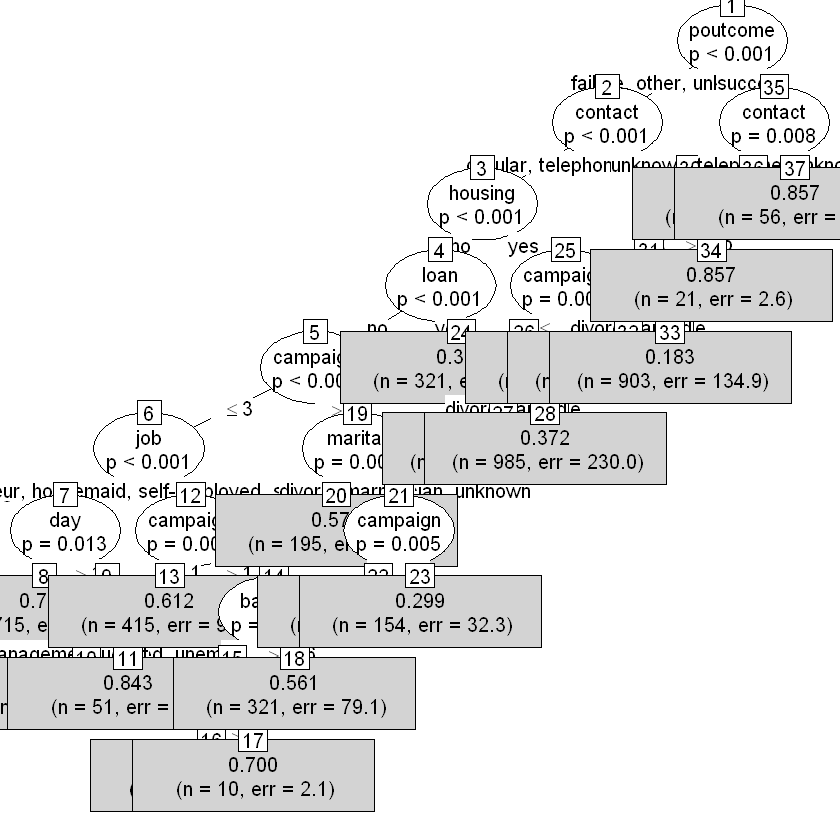

In [57]:
st <- as.simpleparty(party_model)
plot(st)

Додамо прогнозовані показники до раніше створених дата-фрейму для збору результатів:

In [58]:
train_results$PartyPredicted <- predict(party_model, train_data)
test_results$PartyPredicted <- predict(party_model, test_data)
head(test_results)

,No,deposit,RPartPredicted,RPartPredicted_Class,PartyPredicted
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0.2287751,0,0.1827243
2,2,1,0.2287751,0,0.1827243
4,3,1,0.2287751,0,0.1827243
7,4,1,0.2287751,0,0.1827243
8,5,1,0.2287751,0,0.2746365
9,6,1,0.2287751,0,0.1827243


Визначимо оптимальну лінію розділення на класи 0 і 1:

In [59]:
optCutOff <- optimalCutoff(train_results$deposit, train_results$PartyPredicted)
optCutOff

[1] 0.4746468

ROC-крива та AUROC:

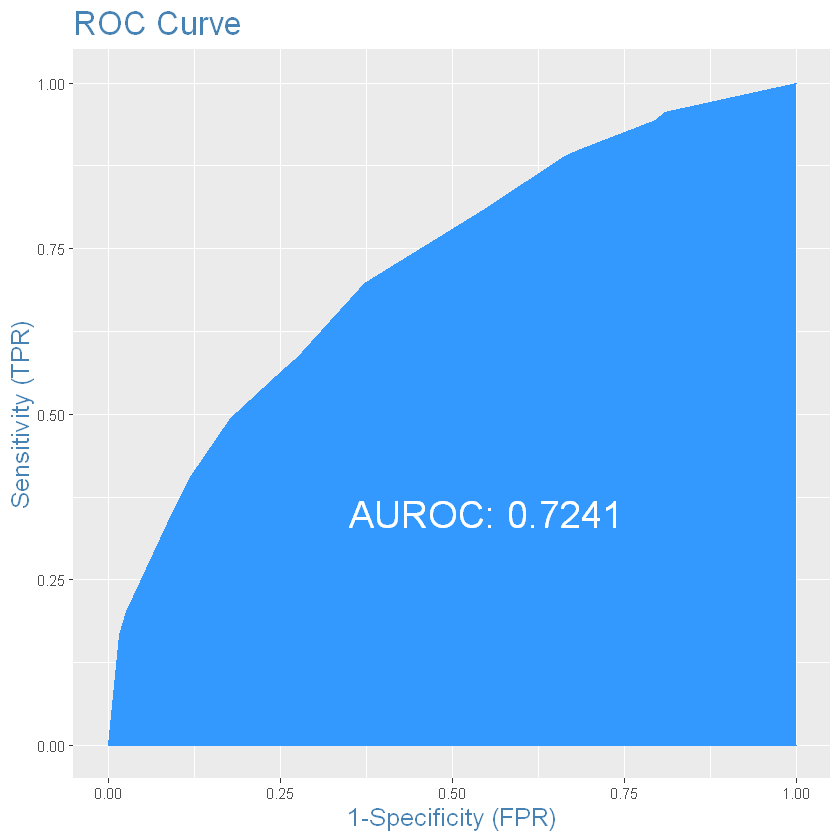

In [60]:
plotROC(test_results$deposit, test_results$PartyPredicted)

Розділимо результати прогнозування на класи:

In [61]:
test_results$PartyPredicted_Class <- ifelse(test_results$PartyPredicted > optCutOff, 1, 0)

Confusion matrix:

In [62]:
cm <- caret::confusionMatrix(factor(test_results$deposit), 
                             factor(test_results$PartyPredicted_Class), 
                             positive = "1")
cm

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1535  522
         1  803 1046
                                          
               Accuracy : 0.6608          
                 95% CI : (0.6457, 0.6756)
    No Information Rate : 0.5986          
    P-Value [Acc > NIR] : 6.520e-16       
                                          
                  Kappa : 0.3144          
                                          
 Mcnemar's Test P-Value : 1.446e-14       
                                          
            Sensitivity : 0.6671          
            Specificity : 0.6565          
         Pos Pred Value : 0.5657          
         Neg Pred Value : 0.7462          
             Prevalence : 0.4014          
         Detection Rate : 0.2678          
   Detection Prevalence : 0.4734          
      Balanced Accuracy : 0.6618          
                                          
       'Positive' Class : 1               
                        

Оцінимо збалансовану точність класифікації:

In [63]:
BAcc # value for previous model

[1] 0.6555377

In [64]:
BAcc1 <- cm$byClass[["Balanced Accuracy"]]
BAcc1

[1] 0.6618179

---

## Desision Tree with c50

Скористаємося алгоритмом `C50` для побудови дерева рішень.
Для початку потрібно виіхдний показник перетворити у категоріальний (`factor`):

In [65]:
# lets make anew temporary dataset for modeling with target output as factor

In [66]:
train_data_tmp <- train_data %>%
    mutate(deposit = factor(train_data$deposit, levels = c(0,1)))

test_data_tmp <- test_data %>%
    mutate(deposit = factor(test_data$deposit, levels = c(0,1)))

Побудуємо модель:

In [67]:
library(C50)
c5_model <- C5.0(deposit ~ ., data = train_data_tmp)

Переглянемо модель:

In [68]:
summary(c5_model)
# its hard to check the nodes


Call:
C5.0.formula(formula = deposit ~ ., data = train_data_tmp)


C5.0 [Release 2.07 GPL Edition]  	Mon Oct 03 18:54:18 2022
-------------------------------

Class specified by attribute `outcome'

Read 7256 cases (18 attributes) from undefined.data

Decision tree:

poutcoume_success > 0: 1 (693/56)
poutcoume_success <= 0:
:...pdays > 374: 1 (75/10)
    pdays <= 374:
    :...age > 60: 1 (292/66)
        age <= 60:
        :...contact = unknown:
            :...poutcome = success: 0 (0)
            :   poutcome in {failure,other}: 1 (3)
            :   poutcome = unknown:
            :   :...month in [oct-dec]: 1 (20/2)
            :       month in [jan-sep]:
            :       :...month in [jan-apr]: 1 (10/1)
            :           month in [may-sep]:
            :           :...marital = married: 0 (893/157)
            :               marital in {divorced,single}:
            :               :...default = yes:
            :                   :...marital = divorced: 0 (7/2)
      

Здійснимо прогноз значень:

In [69]:
train_results$C5Predicted <- predict(c5_model, train_data_tmp)
test_results$C5Predicted <- predict(c5_model, test_data_tmp)

ROC-крива та AUROC:

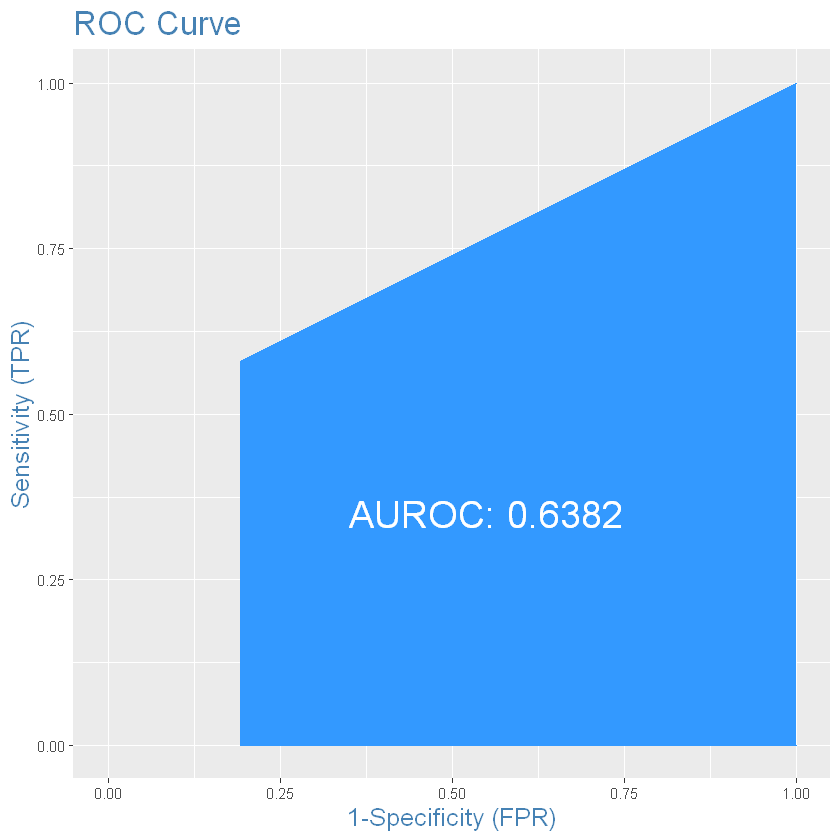

In [70]:
plotROC(as.numeric(test_results$deposit), as.numeric(test_results$C5Predicted))
# you can see that current algorithm is not very good for this data, partykit is much better

Confusion Matrix:

In [71]:
cm <- caret::confusionMatrix(factor(test_results$deposit), 
                             test_results$C5Predicted, 
                             positive = "1")
cm

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1662  395
         1  777 1072
                                          
               Accuracy : 0.6999          
                 95% CI : (0.6853, 0.7143)
    No Information Rate : 0.6244          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3918          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7307          
            Specificity : 0.6814          
         Pos Pred Value : 0.5798          
         Neg Pred Value : 0.8080          
             Prevalence : 0.3756          
         Detection Rate : 0.2744          
   Detection Prevalence : 0.4734          
      Balanced Accuracy : 0.7061          
                                          
       'Positive' Class : 1               
                        

Збалансована точність моделі:

In [72]:
BAcc # rpart
BAcc1 # partykit

[1] 0.6555377

[1] 0.6618179

In [73]:
BAcc2 <- cm$byClass[["Balanced Accuracy"]]
BAcc2
# but balanced accuracy is the best. So this model better classify both good and bad events

[1] 0.7060849

---

## RandomForest

You can use `random forest` with default or special training parameters. 

In [74]:
head(train_results)

,No,deposit,RPartPredicted,PartyPredicted,C5Predicted
,<int>,<dbl>,<dbl>,<dbl>,<fct>
3,1,1,0.2287751,0.1827243,0
5,2,1,0.2287751,0.1827243,0
6,3,1,0.2287751,0.2746365,0
11,4,1,0.2287751,0.2746365,0
12,5,1,0.2287751,0.1827243,0
14,6,1,0.2287751,0.2746365,0


In [75]:
head(train_data)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,pdays_flag,poutcoume_success
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<ord>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>
3,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,1,0,0
5,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,1,0,0
6,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,2,-1,0,unknown,1,0,0
11,38,admin.,single,secondary,no,100,yes,no,unknown,7,may,1,-1,0,unknown,1,0,0
12,30,blue-collar,married,secondary,no,309,yes,no,unknown,7,may,2,-1,0,unknown,1,0,0
14,46,blue-collar,single,tertiary,no,460,yes,no,unknown,7,may,2,-1,0,unknown,1,0,0


In [76]:
#install.packages("randomForest")

In [77]:
table(train_data$deposit)


   0    1 
3816 3440 

In [78]:
suppressMessages(library(randomForest))

rf_model <- randomForest(deposit ~ ., 
                         data=train_data, 
                         ntree=200, 
                         mtry=2, 
                         importance=TRUE) #Should importance of predictors be assessed?

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


`ntree` - Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.

`mtry` - Number of variables randomly sampled as candidates at each split.

In [79]:
rf_model


Call:
 randomForest(formula = deposit ~ ., data = train_data, ntree = 200,      mtry = 2, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 200
No. of variables tried at each split: 2

          Mean of squared residuals: 0.1909128
                    % Var explained: 23.43

Можемо провести аналіз важливості параметрів у залежності від критерію `зменшення точності` або `зменшення джині`:

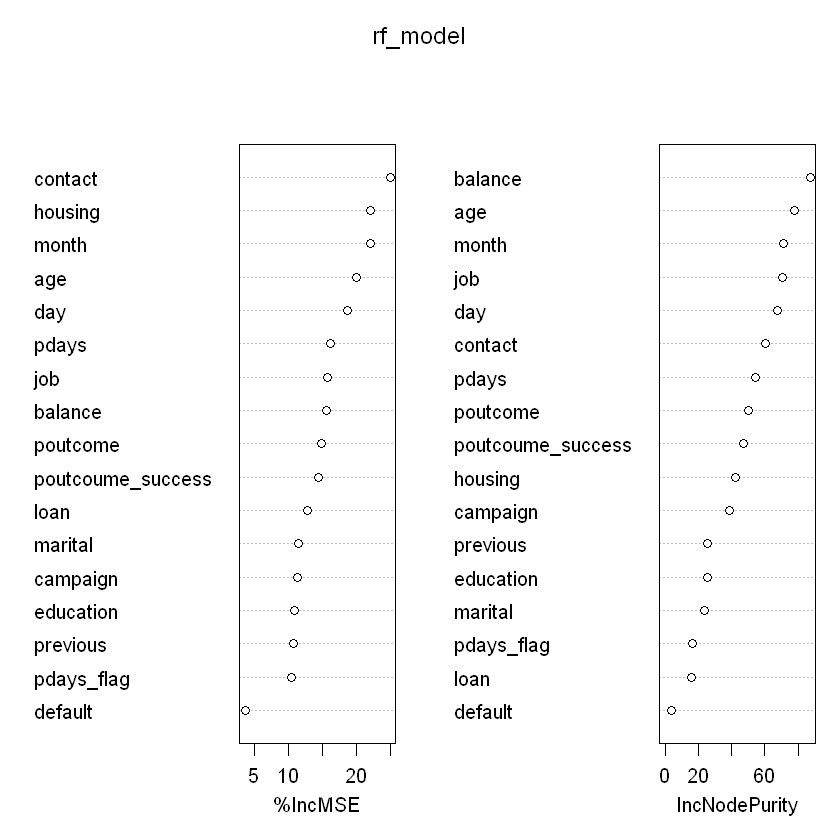

In [80]:
varImpPlot(rf_model)

- [x] `MeanDecreaseAccuracy`: gives a rough estimate of the loss in prediction performance when that particular variable is omitted from the training set. Caveat: if two variables are somewhat redundant, then omitting one of them may not lead to massive gains in prediction performance, but would make the second variable more important.

- [x] `MeanDecreaseGini`: GINI is a measure of node impurity. Think of it like this, if you use this feature to split the data, how pure will the nodes be? Highest purity means that each node contains only elements of a single class. Assessing the decrease in GINI when that feature is omitted leads to an understanding of how important that feature is to split the data correctly.

In [81]:
train_results$RF <- predict(rf_model, train_data)
test_results$RF <- predict(rf_model, test_data)

In [82]:
optCutOff <- optimalCutoff(train_results$deposit, train_results$RF)
optCutOff

[1] 0.4269683

In [83]:
test_results$RF_Class = ifelse(test_results$RF > optCutOff, 1, 0)

ROC-крива та AUROC:

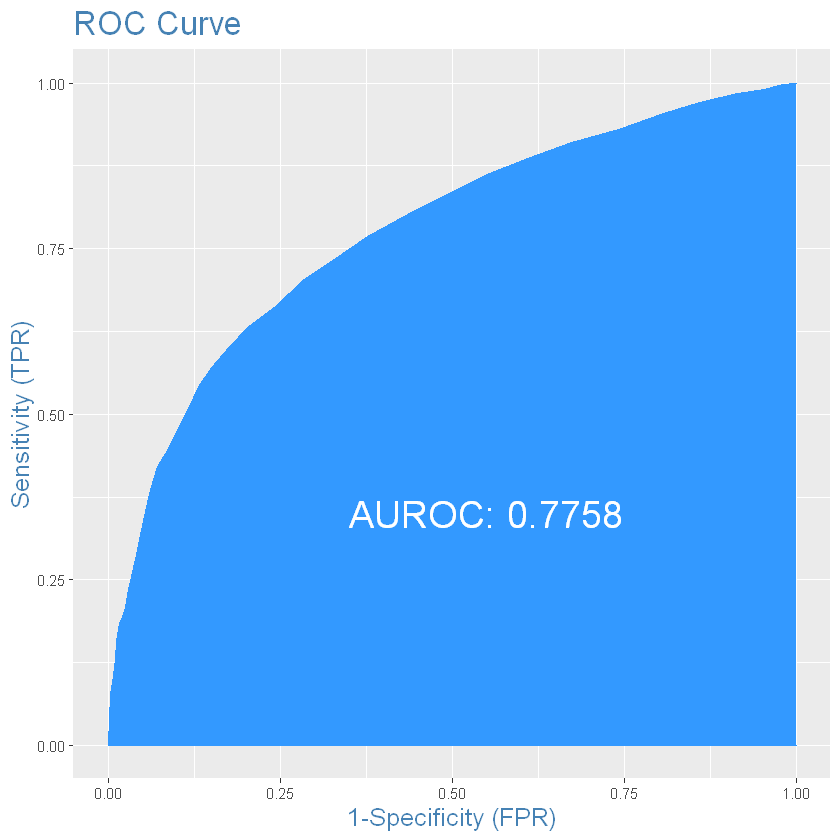

In [84]:
plotROC(as.numeric(test_results$deposit), as.numeric(test_results$RF))

In [85]:
# Balanced accuracy is much better the before!
cm <- caret::confusionMatrix(factor(test_results$deposit), 
                             factor(test_results$RF_Class), 
                             positive = "1")
cm

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1411  646
         1  506 1343
                                          
               Accuracy : 0.7051          
                 95% CI : (0.6905, 0.7193)
    No Information Rate : 0.5092          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4107          
                                          
 Mcnemar's Test P-Value : 4.216e-05       
                                          
            Sensitivity : 0.6752          
            Specificity : 0.7360          
         Pos Pred Value : 0.7263          
         Neg Pred Value : 0.6860          
             Prevalence : 0.5092          
         Detection Rate : 0.3438          
   Detection Prevalence : 0.4734          
      Balanced Accuracy : 0.7056          
                                          
       'Positive' Class : 1               
                        

Balanced accuracy is hte best for now

---

## xgBoost

Our next step is testing gradient boosting with `xgboost` algorithm.

In [86]:
suppressMessages(library(xgboost))

For complex algorithm like `random forest` or `xgboost` model training is the most important stage.

XGBoost only works with numeric vectors. Therefore, you need to convert all other forms of data into numeric vectors.

In [87]:
train_labels <- train_data$deposit
test_labels <- test_data$deposit

xgb_train_data <- xgb.DMatrix(data = model.matrix(deposit~., data = train_data),
                              label = train_labels)
xgb_test_data <- xgb.DMatrix(data = model.matrix(deposit~., data = test_data),
                              label = test_labels)
xgb_test_data

xgb.DMatrix  dim: 3906 x 44  info: label  colnames: yes

We will train decision tree model using the following parameters:

- [x] `objective = "binary:logistic"`: we will train a binary classification model ;
- [x] `max.depth = 2`: the trees won’t be deep, because our case is very simple ;
- [x] `nthread = 2`: the number of CPU threads we are going to use;
- [x] `nrounds = 2`: there will be two passes on the data, the second one will enhance the model by further reducing the difference between ground truth and prediction.

In [88]:
xgb_model <- xgboost(data = xgb_train_data, 
                     label = train_labels, 
                     max.depth = 2, 
                     #eta = 1, 
                     nthread = 2, 
                     nrounds = 2, 
                     objective = "binary:logistic")
xgb_model

Warning message in xgb.get.DMatrix(data, label, missing, weight, nthread = merged$nthread):
"xgboost: label will be ignored."


[1]	train-logloss:0.659975 
[2]	train-logloss:0.635883 


##### xgb.Booster
raw: 5.8 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max.depth = 2, nthread = 2, objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "2", nthread = "2", objective = "binary:logistic", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 44 
niter: 2
nfeatures : 44 
evaluation_log:
 iter train_logloss
    1     0.6599753
    2     0.6358826

In [89]:
# predict data
train_results$XGB <- predict(xgb_model, xgb_train_data)
test_results$XGB <- predict(xgb_model, xgb_test_data)

head(test_results)

,No,deposit,RPartPredicted,RPartPredicted_Class,PartyPredicted,PartyPredicted_Class,C5Predicted,RF,RF_Class,XGB
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,1,1,0.2287751,0,0.1827243,0,0,0.2377513,0,0.3903929
2,2,1,0.2287751,0,0.1827243,0,0,0.2456910,0,0.3903929
4,3,1,0.2287751,0,0.1827243,0,0,0.2173557,0,0.3903929
7,4,1,0.2287751,0,0.1827243,0,0,0.2370295,0,0.3903929
8,5,1,0.2287751,0,0.2746365,0,0,0.3459498,0,0.3903929
9,6,1,0.2287751,0,0.1827243,0,0,0.1872509,0,0.3903929


Optimal cutoff:

In [90]:
optCutOff <- optimalCutoff(train_results$deposit, train_results$XGB)
optCutOff

[1] 0.4731132

In [91]:
# evaluate classification class
test_results$XGB_Class = ifelse(test_results$XGB > optCutOff, 1, 0)

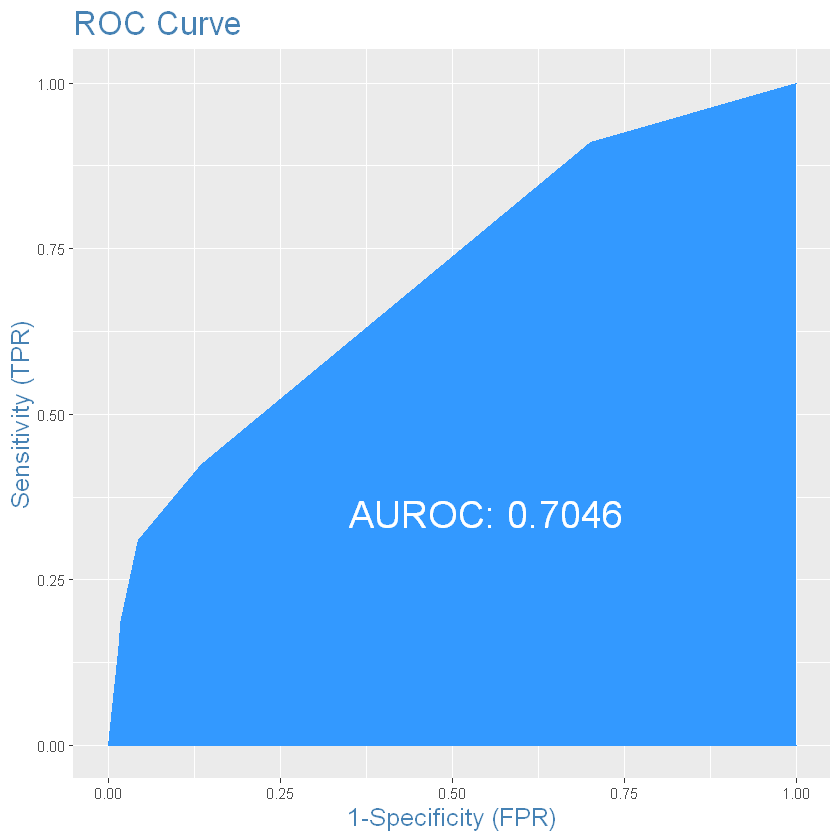

In [92]:
plotROC(as.numeric(test_results$deposit), as.numeric(test_results$XGB))

In [93]:
# Balanced accuracy is not better, random forest wins for now!
cm <- caret::confusionMatrix(factor(test_results$deposit), 
                             factor(test_results$XGB_Class), 
                             positive = "1")
cm

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1777  280
         1 1065  784
                                          
               Accuracy : 0.6557          
                 95% CI : (0.6405, 0.6706)
    No Information Rate : 0.7276          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2942          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7368          
            Specificity : 0.6253          
         Pos Pred Value : 0.4240          
         Neg Pred Value : 0.8639          
             Prevalence : 0.2724          
         Detection Rate : 0.2007          
   Detection Prevalence : 0.4734          
      Balanced Accuracy : 0.6811          
                                          
       'Positive' Class : 1               
                        

---

## lightgbm 

Light gbm is one of most useful package for machine learning. It has one super power: speed of calculations. While you using very big datasets `randomForest` and `xgBoost` work slow, but `lightgbm` works better.

For this algorithm we should convert our data to special matrices too. So, lets install packages for example:

In [94]:
# ALERT sometimes you need to unistall Matrix in RSTudio and install it again
suppressMessages(library(Matrix))                      
suppressMessages(library(lightgbm))

Lets use binning technique for data preprocessing 

In [95]:
suppressMessages(library(scorecard))

In [96]:
vars_list <- train_data %>%
  select(-deposit) %>%
  names()
vars_list

[1] "age"               "job"               "marital"          
 [4] "education"         "default"           "balance"          
 [7] "housing"           "loan"              "contact"          
[10] "day"               "month"             "campaign"         
[13] "pdays"             "previous"          "poutcome"         
[16] "pdays_flag"        "poutcoume_success"

In [97]:
bin_class <- woebin(train_data, 
                    y = "deposit", 
                    x = vars_list, 
                    positive = 1, # the value in deposit that indicates event                   
                    bin_num_limit = 20)
# bin_class - to check bins

[INFO] creating woe binning ... 


In [98]:
train_woe <- woebin_ply(train_data, bin_class)
test_woe <- woebin_ply(test_data, bin_class)
head(train_woe)

[INFO] converting into woe values ... 
[INFO] converting into woe values ... 


deposit,age_woe,job_woe,marital_woe,education_woe,default_woe,balance_woe,housing_woe,loan_woe,contact_woe,day_woe,month_woe,campaign_woe,pdays_woe,previous_woe,poutcome_woe,pdays_flag_woe,poutcoume_success_woe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.1919797,0.18206313,-0.1591497,-0.1114005,0,0.34944916,-0.4636881,0.08789815,-1.11036,-0.2931007,-0.6621753,0.22554244,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
1,-0.1919797,-0.02410209,-0.1591497,0.2697353,0,-0.34928490,0.4042223,0.08789815,-1.11036,-0.2931007,-0.6621753,-0.03160046,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
1,-0.1919797,0.17010635,0.2785068,0.2697353,0,-0.34928490,-0.4636881,-0.61989139,-1.11036,-0.2931007,-0.6621753,-0.03160046,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
1,-0.1919797,-0.02410209,0.2785068,-0.1114005,0,-0.34928490,-0.4636881,0.08789815,-1.11036,-0.2931007,-0.6621753,0.22554244,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
1,-0.1919797,-0.47176755,-0.1591497,-0.1114005,0,-0.05026394,-0.4636881,0.08789815,-1.11036,-0.2931007,-0.6621753,-0.03160046,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
1,-0.1919797,-0.47176755,0.2785068,0.2697353,0,-0.05026394,-0.4636881,0.08789815,-1.11036,-0.2931007,-0.6621753,-0.03160046,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974


In [99]:
vars_list <- train_woe %>%
  select(-deposit) %>%
  names() 
vars_list

[1] "age_woe"               "job_woe"               "marital_woe"          
 [4] "education_woe"         "default_woe"           "balance_woe"          
 [7] "housing_woe"           "loan_woe"              "contact_woe"          
[10] "day_woe"               "month_woe"             "campaign_woe"         
[13] "pdays_woe"             "previous_woe"          "poutcome_woe"         
[16] "pdays_flag_woe"        "poutcoume_success_woe"

In [100]:
head(test_woe %>% select(vars_list))

Note: Using an external vector in selections is ambiguous.
i Use `all_of(vars_list)` instead of `vars_list` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


age_woe,job_woe,marital_woe,education_woe,default_woe,balance_woe,housing_woe,loan_woe,contact_woe,day_woe,month_woe,campaign_woe,pdays_woe,previous_woe,poutcome_woe,pdays_flag_woe,poutcoume_success_woe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.1919797,-0.02410209,-0.15914969,-0.1114005,0,0.34944916,-0.4636881,0.08789815,-1.11036,-0.2931007,-0.6621753,0.2255424,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
-0.1919797,-0.02410209,-0.15914969,-0.1114005,0,-0.34928490,0.4042223,0.08789815,-1.11036,-0.2931007,-0.6621753,0.2255424,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
-0.1919797,-0.26465641,-0.15914969,-0.1114005,0,0.34944916,-0.4636881,0.08789815,-1.11036,-0.2931007,-0.6621753,0.2255424,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
-0.1919797,0.17010635,-0.15914969,0.2697353,0,0.34944916,-0.4636881,-0.61989139,-1.11036,-0.2931007,-0.6621753,0.2255424,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
1.2441251,0.73838226,0.01571154,-0.1114005,0,-0.05026394,-0.4636881,0.08789815,-1.11036,-0.2931007,-0.6621753,0.2255424,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974
-0.1919797,0.18206313,-0.15914969,-0.1114005,0,-0.34928490,-0.4636881,0.08789815,-1.11036,-0.2931007,-0.6621753,0.2255424,-0.2605003,-0.2597224,-0.2592721,-0.2597224,-0.1899974


In [101]:
train_sparse = Matrix(as.matrix(train_woe %>% select(vars_list)), sparse=TRUE)
test_sparse = Matrix(as.matrix(test_woe %>% select(vars_list)), sparse=TRUE)

In [102]:
lgb.train = lgb.Dataset(data = train_sparse, label = train_woe$deposit, free_raw_data = FALSE)
lgb.test = lgb.Dataset(data = test_sparse, label = test_woe$deposit, free_raw_data = FALSE)


In [103]:
lgb.grid = list(objective = "binary",
                metric = "auc",
                #save_binary = T,
                max_bin = 32,
                num_leaves = 33)

In [104]:
lgb.train.cv = lgb.train(params = lgb.grid,
                         data = lgb.train,                         
                         nrounds = 15,                         
                         early_stopping_round = 300,
                         #categorical_feature = categoricals.vec,
                         valids = list(test = lgb.test),
                         verbose = 1) 

[LightGBM] [Info] Number of positive: 3440, number of negative: 3816
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 7256, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.474090 -> initscore=-0.103731
[LightGBM] [Info] Start training from score -0.103731
[1] "[1]:  test's auc:0.759236"
[1] "[2]:  test's auc:0.760231"
[1] "[3]:  test's auc:0.763489"
[1] "[4]:  test's auc:0.763607"
[1] "[5]:  test's auc:0.763681"
[1] "[6]:  test's auc:0.763814"
[1] "[7]:  test's auc:0.762936"
[1] "[8]:  test's auc:0.765679"
[1] "[9]:  test's auc:0.766939"
[1] "[10]:  test's auc:0.767712"
[1] "[11]:  test's auc:0.768105"
[1] "[12]:  test's auc:0.768932"
[1] "[13]:  test's auc:0.769262"
[1] "[14]:  test's auc:0

In [105]:
# predict data
train_results$LGBM <- predict(lgb.train.cv, train_sparse)
test_results$LGBM <- predict(lgb.train.cv, test_sparse)

head(test_results)

,No,deposit,RPartPredicted,RPartPredicted_Class,PartyPredicted,PartyPredicted_Class,C5Predicted,RF,RF_Class,XGB,XGB_Class,LGBM
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0.2287751,0,0.1827243,0,0,0.2377513,0,0.3903929,0,0.2076138
2,2,1,0.2287751,0,0.1827243,0,0,0.2456910,0,0.3903929,0,0.1978679
4,3,1,0.2287751,0,0.1827243,0,0,0.2173557,0,0.3903929,0,0.2076138
7,4,1,0.2287751,0,0.1827243,0,0,0.2370295,0,0.3903929,0,0.2076138
8,5,1,0.2287751,0,0.2746365,0,0,0.3459498,0,0.3903929,0,0.2508506
9,6,1,0.2287751,0,0.1827243,0,0,0.1872509,0,0.3903929,0,0.1978679


In [106]:
# Optimal cutoff:

optCutOff <- optimalCutoff(train_results$deposit, train_results$LGBM)
optCutOff

[1] 0.4893173

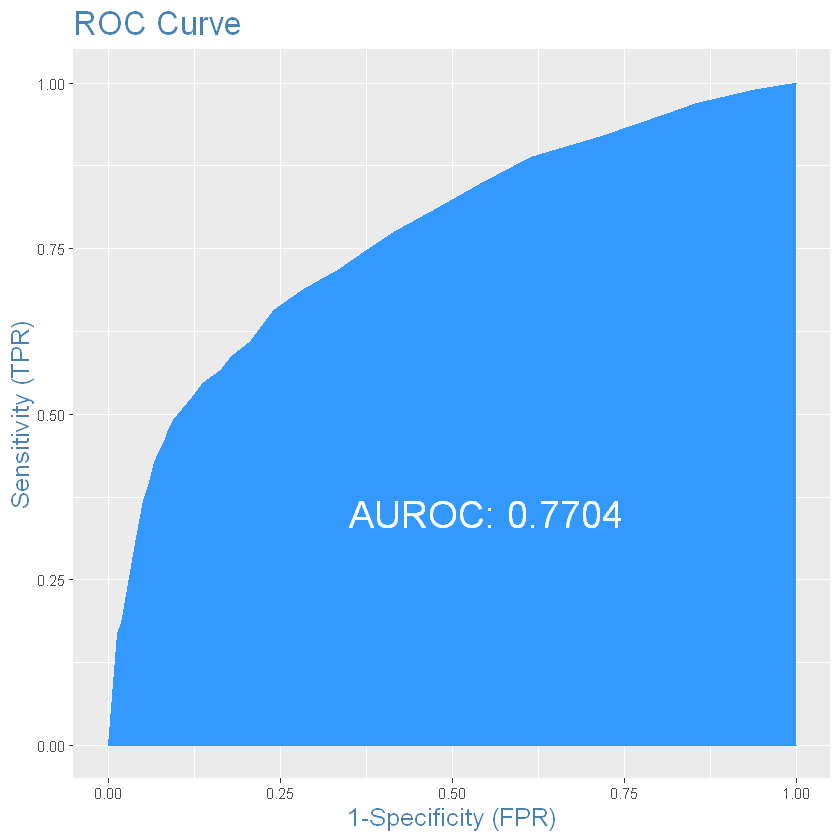

In [107]:
# evaluate classification class
test_results$LGBM_Class = ifelse(test_results$LGBM > optCutOff, 1, 0)
plotROC(as.numeric(test_results$deposit), as.numeric(test_results$LGBM))

In [108]:
# Balanced accuracy is not better, random forest wins for now!
cm <- caret::confusionMatrix(factor(test_results$deposit), 
                             factor(test_results$LGBM_Class), 
                             positive = "1")
cm

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1667  390
         1  741 1108
                                          
               Accuracy : 0.7104          
                 95% CI : (0.6959, 0.7246)
    No Information Rate : 0.6165          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4136          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7397          
            Specificity : 0.6923          
         Pos Pred Value : 0.5992          
         Neg Pred Value : 0.8104          
             Prevalence : 0.3835          
         Detection Rate : 0.2837          
   Detection Prevalence : 0.4734          
      Balanced Accuracy : 0.7160          
                                          
       'Positive' Class : 1               
                        

---